In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from tqdm import tqdm
import pickle

# Introduction

In this notebook, I attempt to determine my taste in music by analyzing the qualities of songs I have liked on Spotify. I then use a clustering algorithm to label songs that I have already liked and use those songs to train a model that will tell me why I may like any additional songs.

# Loading the Data
The data is contained in a .csv file, which I load into a dataframe using Pandas. Each row is a song, and each column is a feature giving some sort of information about songs.

In [2]:
df = pd.read_csv('liked_songs.csv', index_col=0)
print(f'There are {len(df)} rows in the dataframe.')
df.head()

There are 1378 rows in the dataframe.


id                track_name        artist  \
0  6RGz2XOKNscBCybWYDOyd1            The Death Bell        Malist   
1  4M26ooBBPcoWNryE7SS84N            The Antagonist     Insomnium   
2  3Vl5CfD2qmONZUubSRZ0vx                   Nemesis  Stratovarius   
3  6MTFN0DF6yaAmGur1dhb3w        Castles in the Air  Stratovarius   
4  68NSPuJBBVEUKIUSd8pKUb  Unbreakable - Remastered  Stratovarius   

                  album_name album_release_date  album_track_num  \
0             The Death Bell         2022-09-02                1   
1           Argent Moon - EP         2021-09-17                3   
2  Nemesis (Special Edition)         2013-02-22               13   
3  Nemesis (Special Edition)         2013-02-22                7   
4  Nemesis (Special Edition)         2013-02-22                2   

   album_track_placement  genre  duration_ms  explicit  ...  key  loudness  \
0               1.000000    NaN     5.152933     False  ...    9    -4.537   
1               0.750000    NaN     5.059900     False  ...    2    -8.152   
2               1.000000    NaN     6.560667     False  ...    1    -4.221   
3               0.538462    NaN     6.049100     False  ...    1    -4.431   
4               0.153846    NaN     4.625767     False  ...    1    -4.245   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0599      0.000006          0.855000    0.0685   0.1390   
1     1       0.0331      0.000998          0.000023    0.0801   0.2350   
2     0       0.0587      0.000096          0.000141    0.1220   0.0371   
3     0       0.0541      0.000081          0.000014    0.1310   0.5250   
4     0       0.0418      0.000156          0.000113    0.1170   0.6150   

     tempo  time_signature  
0  170.020               4  
1  136.259               3  
2  100.123               4  
3   87.993               4  
4  141.217               4  

[5 rows x 23 columns]

# Data Cleaning

## Checking the Genre Feature
According to Spotify's API documentation, when looking up track info (i.e. not audio features but basic things like album, song and artist names, song durations, etc.) the response should contain an array of genres associated with the track's artist, which will be empty if no genres are assigned to the artist. This does not seem to actually be the case - at least for every artist - and when running a few Google searches, I found people who had similar issues over the past several years. I wrote my code used to retrieve my liked songs from the API to save genre information to a csv if present and enter a NaN value otherwise. Here, I check to see if there was any genre information. If there is not, I drop the feature.

In [3]:
if len(df['genre'].unique()) == 1:
    genre_val = df['genre'].unique()[0]
    print(f'The genre field contains only the following value: {genre_val}.')
    df = df.drop('genre', axis=1) # Drop feature if no genre information
else:
    print('The genre feature contains non-nan values.')

The genre field contains only the following value: nan.


As the genre feature only contained NaN values, it was dropped from the dataframe.

## Encoding Album Release Dates
Spotify does not always have exact release dates for albums. Sometimes it only has release years. For consistency and cleanliness, I will keep only release years for all albums. Values are either in YYYY-MM-DD format or are just the years, so to get years, I split on dashes, and keep only the first entry in the resulting list. If there is just a year, that will result in the year being the first and only entry in the "split" list.

In [4]:
df['album_release_date'] = df['album_release_date'].str.split('-').map(lambda x: int(x[0]))

I rename album_release_date to album_release_year because of the above change. Additionally, I rename duration_ms to duration_min, since the units are minutes.

In [5]:
df = df.rename(columns={'album_release_date':'album_release_year', 'duration_ms':'duration_min'})

# Exploratory Data Analysis
The data consists of numerical, boolean, and other categorical features. The features are listed below, with descriptions provided where not obvious. See [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) for a full description of the audio features.

* General Categorical
    * track_name
    * artist
    * album_name
* Boolean
    * explicit: True if the song is known to contain explicit lyrics, False otherwise
    * mode: whether the songs is written in a major or minor scale
* Numerical
    * album_track_num: the track number on the album
    * album_track_placement: describes  how far the track is through the album, (album_track_num / total tracks on the album)
    * album_release_year: the year in which the album was released
    * duration_min: the track duration in minutes
    * popularity: artist popularity, ranging from 0  (least popular) to 100 (most popular)
    * danceability: how danceable a song is based on factors like tempo, rhythm stability, and beat strength. Ranges from 0 (least danceable) to 1 (most danceable)
    * energy: how energetic a song sounds. Ranges from 0 (least energetic) to 1 (most energetic)
    * key: the key of the track assuming it falls into a 12 tone system. Takes integers from 0 (C) to 11.
    * loudness: average loudness of the track in decibels (i.e. on a log scale)
    * speechiness: how much the song sounds like speech. Ranges from 0 (not at all like speech) to 1 (sounds like exclusively speech)
    * acousticness: confidence that the track is acoustic. Ranges from 0 (very low confidence the track is acoustic) to 1 (very high confidence tha track is acoustic)
    * instrumentalness: confidence that the track contains no vocals. Ranges from 0 (very low confidence the track contains no vocals) to 1 (very high confidence the track contains no vocals)
    * liveness: confidence that the track is live. Ranges from 0 (low confidence) to 1 (high confidence)
    * valence: how positive (as in happy, energetic) the song sounds. Ranges from 0 (sad, angry, etc.) to 1 (happy, energetic, etc.)
    * tempo: the speed of the track in beats per minute
    * time_signature: an integer representation of the time signature. Ranges from 3 as in 3/4 to 7 as in 7/4.

In [6]:
numerical = ['album_track_num', 'album_track_placement', 'album_release_year', 'duration_min', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
boolean = ['mode', 'explicit']
categorical = ['artist_name', 'album_name']
song_info = ['track_name', 'artist', 'album_name']

Out of curiosity, I print the minimum and maximum of the various numerical values. Note that many of these features do not have a unique minimum or maximum (ex. I like multiple songs released in 2022). 

I skip the first two numerical features because they have to do with a track's placement on an album. While the distribution of values in those features may be interesting, simply learning that some songs come at the beginning, middle, or end of an album is not.

In [7]:
for feat in numerical[2:]:
    print(f'________________________{feat.upper()}________________________')
    min_feat_values = df[df[feat] == df[feat].min()][song_info+[feat]].values[0]
    max_feat_values = df[df[feat] == df[feat].max()][song_info+[feat]].values[0]
    print(f'The song with the highest {feat} is {max_feat_values[0]} by {max_feat_values[1]} off of the album {max_feat_values[2]}, with a {feat} value of {max_feat_values[3]}')
    print(f'The song with the lowest {feat} is {min_feat_values[0]} by {min_feat_values[1]} off of the album {min_feat_values[2]}, with a {feat} value of {min_feat_values[3]}\n')

________________________ALBUM_RELEASE_YEAR________________________
The song with the highest album_release_year is The Death Bell by Malist off of the album The Death Bell, with a album_release_year value of 2022
The song with the lowest album_release_year is Suicide by Dust off of the album Hard Attack/Dust, with a album_release_year value of 1972

________________________DURATION_MIN________________________
The song with the highest duration_min is Monolithe IV by Monolithe off of the album Monolithe IV, with a duration_min value of 57.00376666666667
The song with the lowest duration_min is I Accept Your Last Wish by Gridlink off of the album Orphan, with a duration_min value of 0.9682166666666668

________________________POPULARITY________________________
The song with the highest popularity is C.R.E.A.M. (Cash Rules Everything Around Me) (feat. Method Man, Raekwon, Inspectah Deck & Buddha Monk) by Wu-Tang Clan off of the album Enter The Wu-Tang (36 Chambers) [Expanded Edition], wit

Most of the above are very sensible, with the exception of a few values that suggest errors on Spotify's end. For brevity, I will only discuss potential errors.

Sepal by Emptyset is purely instrumental, but Spotify is fairly confident it is largely speech. This feature is almost certainly the result of running songs through a machine learning model, so errors are to be expected.

I suspect the time_signature identification might be unreliable. Spotify assigned a value of 1 to the song In Parting by Be'lakor, but this song is straightforwardly 4/4 and 6/8 (the latter of which is more easily mistaken for 3/4 than no time signature at all to the human listener). Additionally, I know I have liked songs in 7/4, but I have no songs with time_signature = 7. First, I check what time signature Spotify assigns to a song I know is 7/4.

In [8]:
df[df['track_name'] == 'Foe'][song_info+['time_signature']]

track_name   artist album_name  time_signature
961        Foe  Leprous       Coal               1

Similarly to In Parting, this song has a time_signature value of 1. And the percussion in this [song](https://www.youtube.com/watch?v=D61fSxqBLwc) makes the time signature a bit non-obvious, even to a human listener. This makes me think that maybe time_signature values of 1 are assigned if Spotify is unsure of it. I peek at the songs with time_signature = 1 to find out more.

In [9]:
time_sig_1 = df[df['time_signature'] == 1]
print(f'There are {len(time_sig_1)} songs with a time_signature value of 1')
time_sig_1[song_info]

There are 24 songs with a time_signature value of 1


track_name                   artist  \
28                                    In Parting                 Be'lakor   
64                                        Edeste                  Khôrada   
194   Into the Vaults of Ingurgitating Obscurity              Chthe'ilist   
229              Shake My Hand, Bow down and Die              Die Choking   
245                                      Motions     Sun Of The Sleepless   
325                      Within the Dead Horizon                   Inferi   
336                 Self Portrait In Ultramarine                Ben Frost   
365                                         Shed                Meshuggah   
371                                   Clockworks                Meshuggah   
376                         Where Mountains Rise                 Immortal   
410        What a Horrible Night to Have a Curse  The Black Dahlia Murder   
532                                The Architect                    Haken   
533                                         1985                    Haken   
671                                  In Memoriam                    Haken   
748                                        Again     Black Crown Initiate   
787                                   Clockworks                Meshuggah   
905                       Body Bags for the Gods                Katalepsy   
961                                          Foe                  Leprous   
971                                The Architect                    Haken   
972                                         1985                    Haken   
1002                     And the Vulture Beholds      Fleshgod Apocalypse   
1146                        Closed Gates Of Hope                Catamenia   
1232                           March Of The Pigs          Nine Inch Nails   
1309                                 In Memoriam                    Haken   

                                 album_name  
28                       Of Breath and Bone  
64                                     Salt  
194                   Le Dernier Crépuscule  
229                                     III  
245                         To the Elements  
325                                Revenant  
336   All That You Love Will Be Eviscerated  
365                      Catch Thirty Three  
371             The Violent Sleep of Reason  
376                     Northern Chaos Gods  
410                               Nocturnal  
532                                Affinity  
533                                Affinity  
671                            The Mountain  
748                Selves We Cannot Forgive  
787             The Violent Sleep of Reason  
905                           Autopsychosis  
961                                    Coal  
971               Affinity (Deluxe Edition)  
972               Affinity (Deluxe Edition)  
1002                                   King  
1146                         Location: COLD  
1232                    The Downward Spiral  
1309                           The Mountain

These songs fall into a few categories. Some are straightforward 6/8 metal tracks like Where Mountains Rise. Some have multiple odd (but sometimes perfectly countable) time signatures, like The Architect. Two, the Meshuggah tracks, are arguably in 4/4 but can be hard to follow. And one, Self Portrait in Ultramarine has no discernible time signature. But suppose Spotify labeled any track with those characteristics as having a time signature of 1. I would then expect a lot more songs to receive this label. So many metal songs are in 6/8 it is almost cliche, I would expect many more songs with the label because of odd time signature changes, every Meshuggah song I have liked can be described as "arguably 4/4 but can be hard to follow," and ambient, drone, and most noise usually have no discernible time signature. In short, the labels seem to be errors on Spotify's part, but it unclear what causes labelling error.

At this point, I ran some Google searches to see if people had similar issues with this feature. They have, and it seems to be the case that time_signature = 1 indicates a sort of outlier (see, e.g. [here](https://github.com/spotify/web-api/issues/379)). The time signatures, as one would expect, are assigned using machine learning models. But these models are not perfect, and sometimes assign incorrect values. This being the case, I keep the feature in the dataset.

# Univariate Distributions
I plot univariate plots of the various features below.

## Numerical Features
Numerical features are those that naturally take on numerical values, like the release year of a track or its tempo.

Before plotting the numerical features, we can see some descriptive statistics, specifically the mean, standard deviation, minimum, maximum and quartiles for each numerical feature.

In [10]:
df.describe()

album_release_year  album_track_num  album_track_placement  \
count         1378.000000      1378.000000            1378.000000   
mean          2010.855588         4.145864               0.433626   
std              7.595734         2.960608               0.279968   
min           1972.000000         1.000000               0.030303   
25%           2008.000000         2.000000               0.200000   
50%           2013.000000         3.000000               0.375000   
75%           2016.000000         6.000000               0.625000   
max           2022.000000        16.000000               1.000000   

       duration_min   popularity  danceability       energy          key  \
count   1378.000000  1378.000000   1378.000000  1378.000000  1378.000000   
mean       6.176655    14.272134      0.337448     0.826955     5.198839   
std        3.576796    15.603683      0.144847     0.198786     3.589454   
min        0.968217     0.000000      0.059300     0.000707     0.000000   
25%        4.213446     0.000000      0.217000     0.764000     2.000000   
50%        5.313667    10.000000      0.336500     0.908000     5.000000   
75%        7.186229    25.000000      0.444000     0.961750     8.000000   
max       57.003767    76.000000      0.903000     0.999000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  1378.000000  1378.000000  1378.000000   1378.000000       1378.000000   
mean     -6.567206     0.567489     0.085924      0.053173          0.437349   
std       3.420853     0.495604     0.060864      0.171241          0.371496   
min     -42.238000     0.000000     0.024900      0.000000          0.000000   
25%      -7.782500     0.000000     0.046000      0.000020          0.012675   
50%      -5.808000     1.000000     0.068800      0.000211          0.468500   
75%      -4.537750     1.000000     0.103000      0.004672          0.816750   
max       2.121000     1.000000     0.798000      0.985000          0.995000   

          liveness      valence        tempo  time_signature  
count  1378.000000  1378.000000  1378.000000     1378.000000  
mean      0.221943     0.211538   124.117669        3.812772  
std       0.165775     0.166097    29.383985        0.541452  
min       0.020400     0.021500    56.542000        1.000000  
25%       0.104000     0.080925   102.451250        4.000000  
50%       0.156000     0.165000   120.064000        4.000000  
75%       0.312000     0.300750   143.944250        4.000000  
max       0.970000     0.964000   200.188000        5.000000

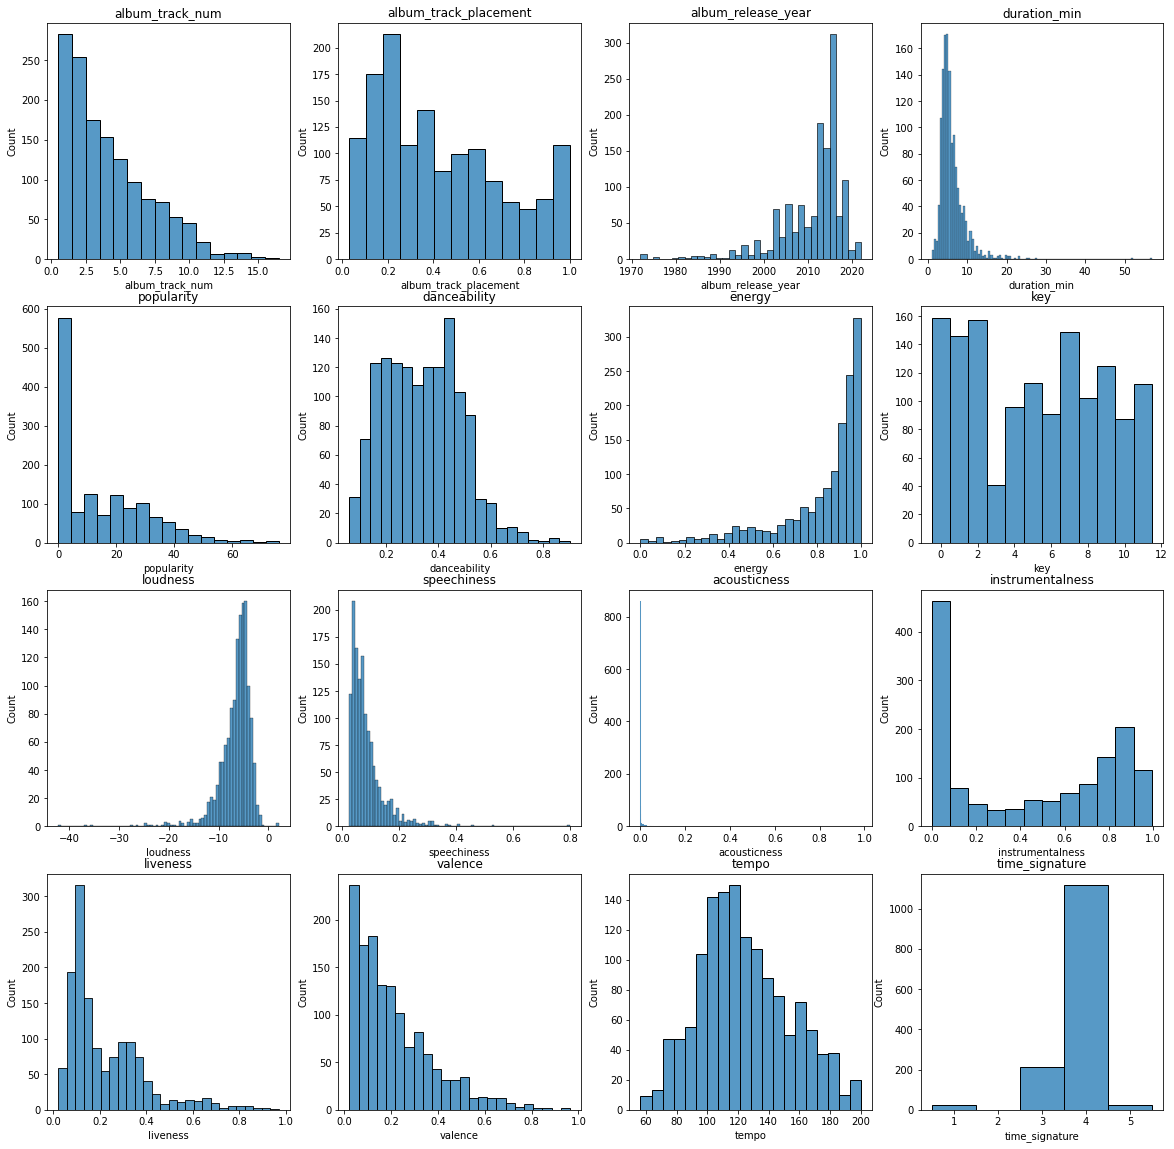

In [11]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, discrete=True, ax=ax)
    else:
        sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)
plt.show()

Ignoring suspicions about the time_signature feature, all of these are either unsurprising or at least plausible. Two standout plots are the duration and acousticness plotS. The first I assume has no outliers but rather reflects the inclusion of a few doom songs that are effectively entire albums that aren't broken into tracks. Specifically, the inclusion of songs up to 20 minutes long raises no read flags. The second likely just reflects my taste, which is mostly music that is hard to mistake for acoustic music.

Note that the time_signature feature has relatively few values of 1.

I examine the duration feature in a bit more detail to ensure there are no outliers, then I do the same for the acousticness feature

### Duration

In [12]:
df[df['duration_min'] > 20][song_info + ['duration_min']]

track_name                       artist  \
177                  Unending Grey                   Hope Drone   
181              Klippens Lyse Hal                          ORM   
308                          Novae                    sunn O)))   
364                 I - Remastered                    Meshuggah   
428                   Monolithe IV                    Monolithe   
551   rockets fall on Rocket Falls  Godspeed You! Black Emperor   
752                 I (Remastered)                    Meshuggah   
993               Bales (Of Flesh)                   Bell Witch   
1055       From a Frozen Wasteland             Midnight Odyssey   
1144                        Teil 1                Nocte Obducta   
1192                     Dark 4.18                    Darkspace   
1214                 Monolithe III                    Monolithe   
1346                 The True Call                  Septic Mind   

                     album_name  duration_min  
177                Cloak of Ash     20.079017  
181                          Ir     23.255633  
308                  Life Metal     25.402050  
364         I (Special Edition)     21.071100  
428                Monolithe IV     57.003767  
551               Yanqui U.X.O.     20.704433  
752         I (Special Edition)     21.071100  
993                     Longing     20.699100  
1055      Shards of Silver Fade     21.906283  
1144  Sequenzen einer Wanderung     23.106000  
1192           Dark Space III I     27.412450  
1214              Monolithe III     52.003333  
1346              The True Call     25.584317

While I do not remember adding all of these songs, they are songs that I plausibly may have added at some point, i.e. not outliers worthy of removal. They are about what was expected - albums or EPs with only 1 track, longer doom songs, and more avant garde tracks.


Next, I examine the acousticness values.

### Acousticness

In [13]:
num_small_acousticness = len(df[df['acousticness'] < 0.05])
print(f'Songs with an acousticness under 0.05 account for {np.round(100*num_small_acousticness/len(df))}% of the tracks.')

Songs with an acousticness under 0.05 account for 87.0% of the tracks.


It would appear from this that I simply tend to like music with low acousticness values. I list some of the songs with acousticness values above 0.05 below.

In [14]:
df[df['acousticness'] >= 0.05][song_info + ['acousticness']].head(20)

track_name                 artist  \
12                 Building Steam With A Grain Of Salt              DJ Shadow   
35                                   Bullhead's Lament               Baroness   
46                                             Minoans            Giant Squid   
48                           ...Of Your Fake Dimension             Com Truise   
63   The Lady with the Golden Stockings (The Golden...                   EABS   
88                                          Impossible               Röyksopp   
89                                          The Ladder               Röyksopp   
112                                To Bid You Farewell                  Opeth   
114                                          Suspended                  Messa   
123                                             Kasvot                  KAUAN   
134  C.O.N.F.O.R.M. (feat. Gift Of Gab, Lateef The ...              DJ Shadow   
135  Rain On Snow (feat. Inspectah Deck, Ghostface ...              DJ Shadow   
136                                   dream is destiny          No Clear Mind   
142                                   The Power Cosmiq            Cannibal Ox   
145                                The Bray Road Beast      The Besnard Lakes   
147                                              Honey                   Moby   
154                  All the Ships Have Been Abandoned    Wreck and Reference   
156                                      Altitude Lake                  SLIFT   
168                       Silhouettes of Death's Grace  The Ruins Of Beverast   
171                                             Gemini       Boards of Canada   

                               album_name  acousticness  
12          Endtroducing (Deluxe Edition)        0.4110  
35           Blue Record (Deluxe Version)        0.0622  
46                                Minoans        0.2780  
48                              Iteration        0.1790  
63                   Discipline of Sun Ra        0.1930  
88                     Profound Mysteries        0.1060  
89                     Profound Mysteries        0.5480  
112                           Morningrise        0.4500  
114                                 Close        0.3130  
123                                 Kaiho        0.6670  
134                      Our Pathetic Age        0.1810  
135                      Our Pathetic Age        0.1660  
136                      Dream is Destiny        0.2920  
142   Blade of the Ronin (Deluxe Edition)        0.2110  
145             A Coliseum Complex Museum        0.4000  
147                  Play & Play: B Sides        0.1300  
154                        Black Cassette        0.0937  
156                                 UMMON        0.3270  
168  Please Don't Walk on the Mass Graves        0.0862  
171                    Tomorrow's Harvest        0.9820

My guess here is that metal tracks are very easy to identify as not being acoustic, which is reasonable as metal almost requires distorted electric guitars. From what I would guess, most of my liked songs are metal, so it makes sense that most songs would have low acousticness values. From 20 random songs with relatively high acousticness values, we see only a few tracks by metal bands, but they do not all fit cleanly in the metal category. The Opeth track is mostly acoustic guitar and fretless bass. The KAUAN song is essentially a post rock songs. The Ruins of Beverast song is closest to a traditional metal song, but relies heavily on clean guitars. The Messa track is the hardest to explain but is not a particularly heavy track, and has some (nearly) clean rhythm guitar work. It also does not have a particularly high acousticness value.

In short, while the acousticness distribution has a lot of samples with very small values, that raises no concern to me.

## Boolean Features
A boolean feature is one that takes on two values.
Both the mode feature (tracking whether a song is major or minor) and the explicit feature (tracking whether a song is explicit) are boolean categorical features.

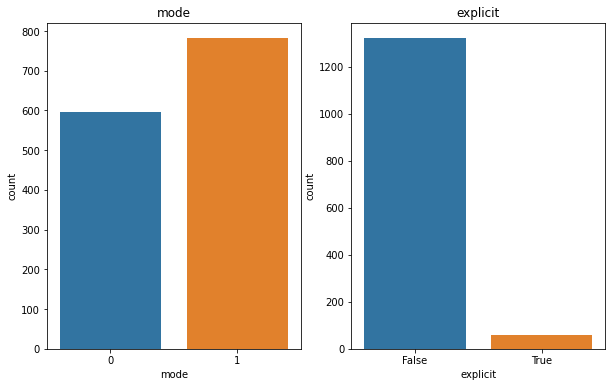

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

for col, ax in zip(boolean, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)
plt.show()

I am skeptical of both of these. The mode feature represents whether songs are major (1) or minor (0). The plot above suggests most of the songs I've liked have been major. While not impossible, I listen to a lot of metal, which makes the plot unlikely. In the more extreme subgenres, writing songs in minor keys is very uncommon to the point using minor keys borders on gimmicky, e.g. many of Mithras' solos. 

The second plot might be misleading. I listen to some unknown but possibly substantial amount of music for which lyrics are not published. These would be listed as not explicit, regardless of lyrical concent. However, I tend not to listen to music with particularly profane or violent lyrics, so the explicit feature is not necessarily implausible.

I look at the modality of some random songs to see whether the plot is plausible.

In [16]:
df.sample(frac=0.1, random_state=321)[song_info + ['mode']].head(15)

track_name                   artist  \
406          The Lonely Deceased  The Black Dahlia Murder   
830   Where Have The Angels Gone              Allen Lande   
1177         God Is In The Radio  Queens of the Stone Age   
1222            Arising Armament                 CHTHONIC   
680                  Three Gates                  Khemmis   
986          Clutching Revulsion                 Ulcerate   
198                   Prophecies           Blind Guardian   
110         Fountain of Nepenthe          Atlantean Kodex   
1000            A Million Deaths      Fleshgod Apocalypse   
1259        Ancient Incantations               Runemagick   
861                      Jealous          House of Wolves   
28                    In Parting                 Be'lakor   
77                   Dream place                GALNERYUS   
931           Crown Of The Kings         Keep Of Kalessin   
642                       Copter            S U R V I V E   

                 album_name  mode  
406           Nightbringers     0  
830              The Battle     1  
1177     Songs For The Deaf     0  
1222                 Bù-Tik     0  
680                  Hunted     1  
986                  Vermis     1  
198   Beyond The Red Mirror     1  
110        The Golden Bough     0  
1000                   King     1  
1259    Darkness Death Doom     1  
861        Fold in the Wind     1  
28       Of Breath and Bone     1  
77      Advance To The Fall     1  
931                  Armada     1  
642                  RR7349     0

These seem fine. 

Finally, I encode the 'explicit' feature. The model needs feature values to be numerical, so I choose True = 1 and False = 0.

In [17]:
df['explicit'] = df['explicit'].astype(int) # Since explicit was boolean, this is equivalent to one-hot encoding

## Other Categorical Features
Artists and albums are categorical features. While I do not plan to include these features in any sort of predictive analysis (since I am more interested in predictions based on the qualities of the music, not artist and album names), it is still interesting to see the variety of unique albums and artists, as well as the albums and songs I tend to "like" the most.

In [18]:
num_unique_bands = len(df['artist'].unique())
num_unique_albums = len(df['album_name'].unique())
print(f'There are {num_unique_albums} albums by {num_unique_bands} bands.')

There are 683 albums by 441 bands.


In [19]:
print('Top 10 most liked artists:')
df['artist'].value_counts().head(10)

Top 10 most liked artists:


Sonata Arctica             23
Agent Fresco               23
Mors Principium Est        21
Meshuggah                  18
Insomnium                  17
GALNERYUS                  16
Children Of Bodom          15
Queens of the Stone Age    14
Omnium Gatherum            13
Masterplan                 13
Name: artist, dtype: int64

In [20]:
print('Top 10 most liked albums:')
df['album_name'].value_counts().head(10)

Top 10 most liked albums:


Destrier                       14
Pariah's Child                 14
Songs For The Deaf             14
The Tides of Damocles          10
Dawn of the 5TH Era             9
Out of the Garden               8
Salt                            8
Destrier (Bonus Edition)        7
Tales Of Ancient Prophecies     7
Hatebreeder                     7
Name: album_name, dtype: int64

Something immediately popped out at me looking at these lists - the lists of bands with songs I liked most frequently and albums with songs I liked most frequently are not comprised mostly of bands or albums I remember enjoying much, or sometimes at all. On closer inspection of my Spotify account, what seems to have happened is that I liked entire albums. Previously, I tended to do this to "keep track" of album, sometimes even before listening to them. This likes all of the tracks on the album and inflates the number of songs by the band that I've liked. That of course presents an inherent problem with the dataset but likely a minor one.

# Bivariate Analysis
For bivariate analysis, I plot correlation coefficients and scatterplots of each feature against each other feature.

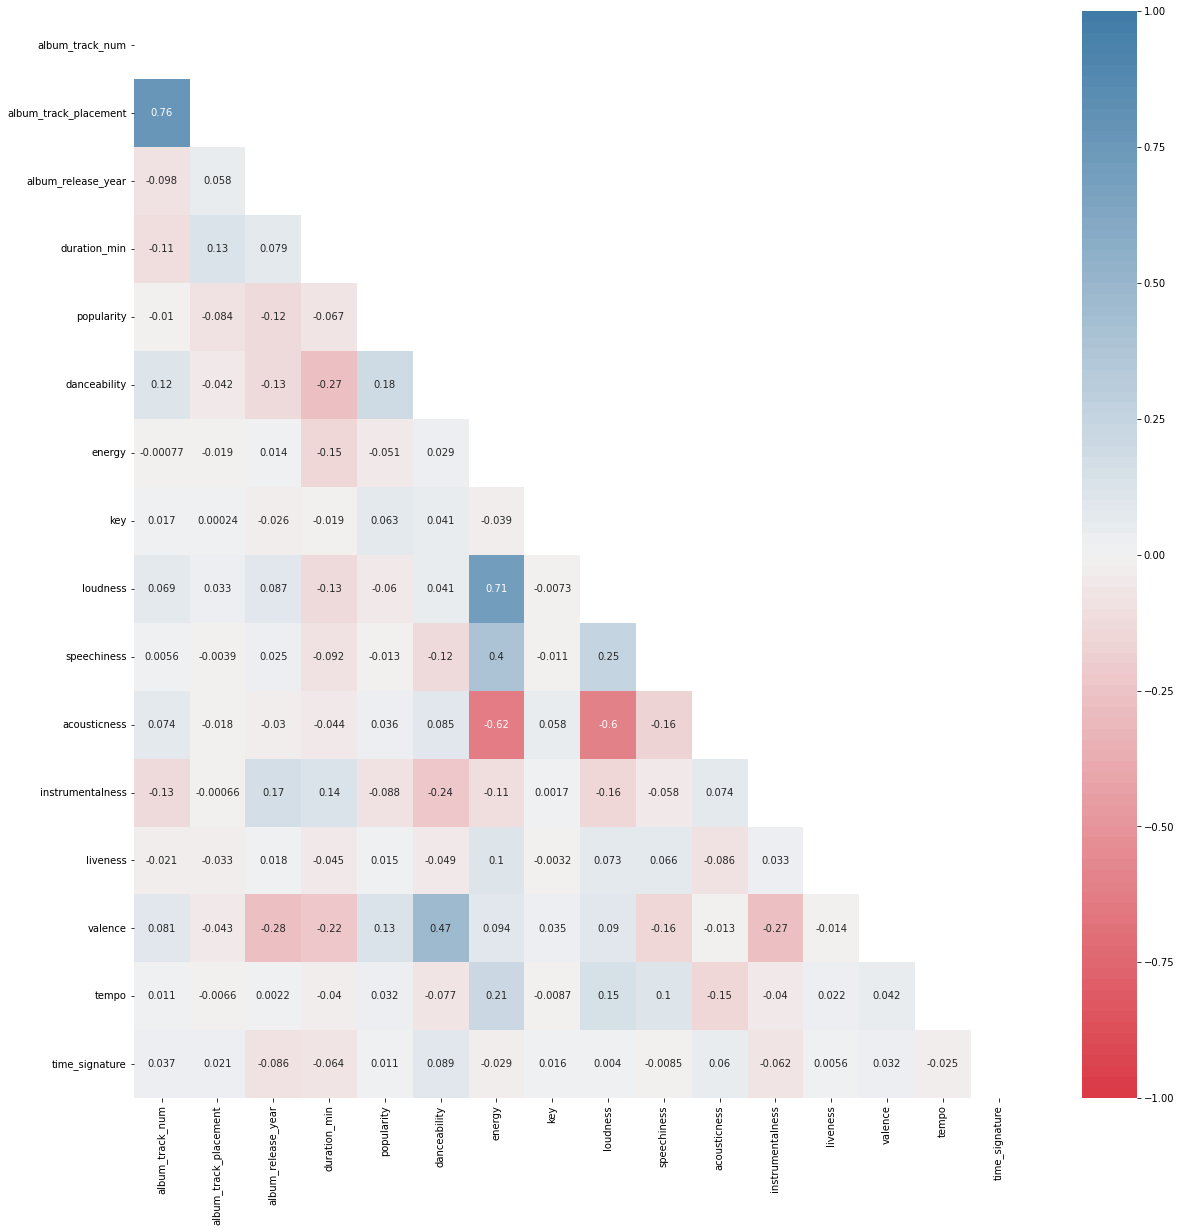

In [21]:
corr = df[numerical].corr()
mask = np.triu(corr)
cmap = sns.diverging_palette(10, 240, n=100)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap=cmap)
plt.show()

The strongest correlations here are pretty obvious. Energy has a strong positive correlation with loudness and negative correlation with accousticness. Loudness has a strong negative correlation with accousticness. These both track common intuition about music, at least modern (mostly) Western music. The correlation between album_track_num and album_track_placement is also trivial given how the latter is defined.

The smaller correlations between album_release_year and instrumetnalness and valence are interesting but merit careful interpretation. To oversimplify a bit, these could reflect either that if a song is released later, I will prefer it more if it is more instrumental or melodic, or it could reflect that my taste in music has led to me liking more sad and instrumental songs as time has gone on. The general warning is not to assume causation from the correlation.

The other caution about these correlation coefficients is that they track linear relationships. Non-linear relationships will show up on the scatterplots below.

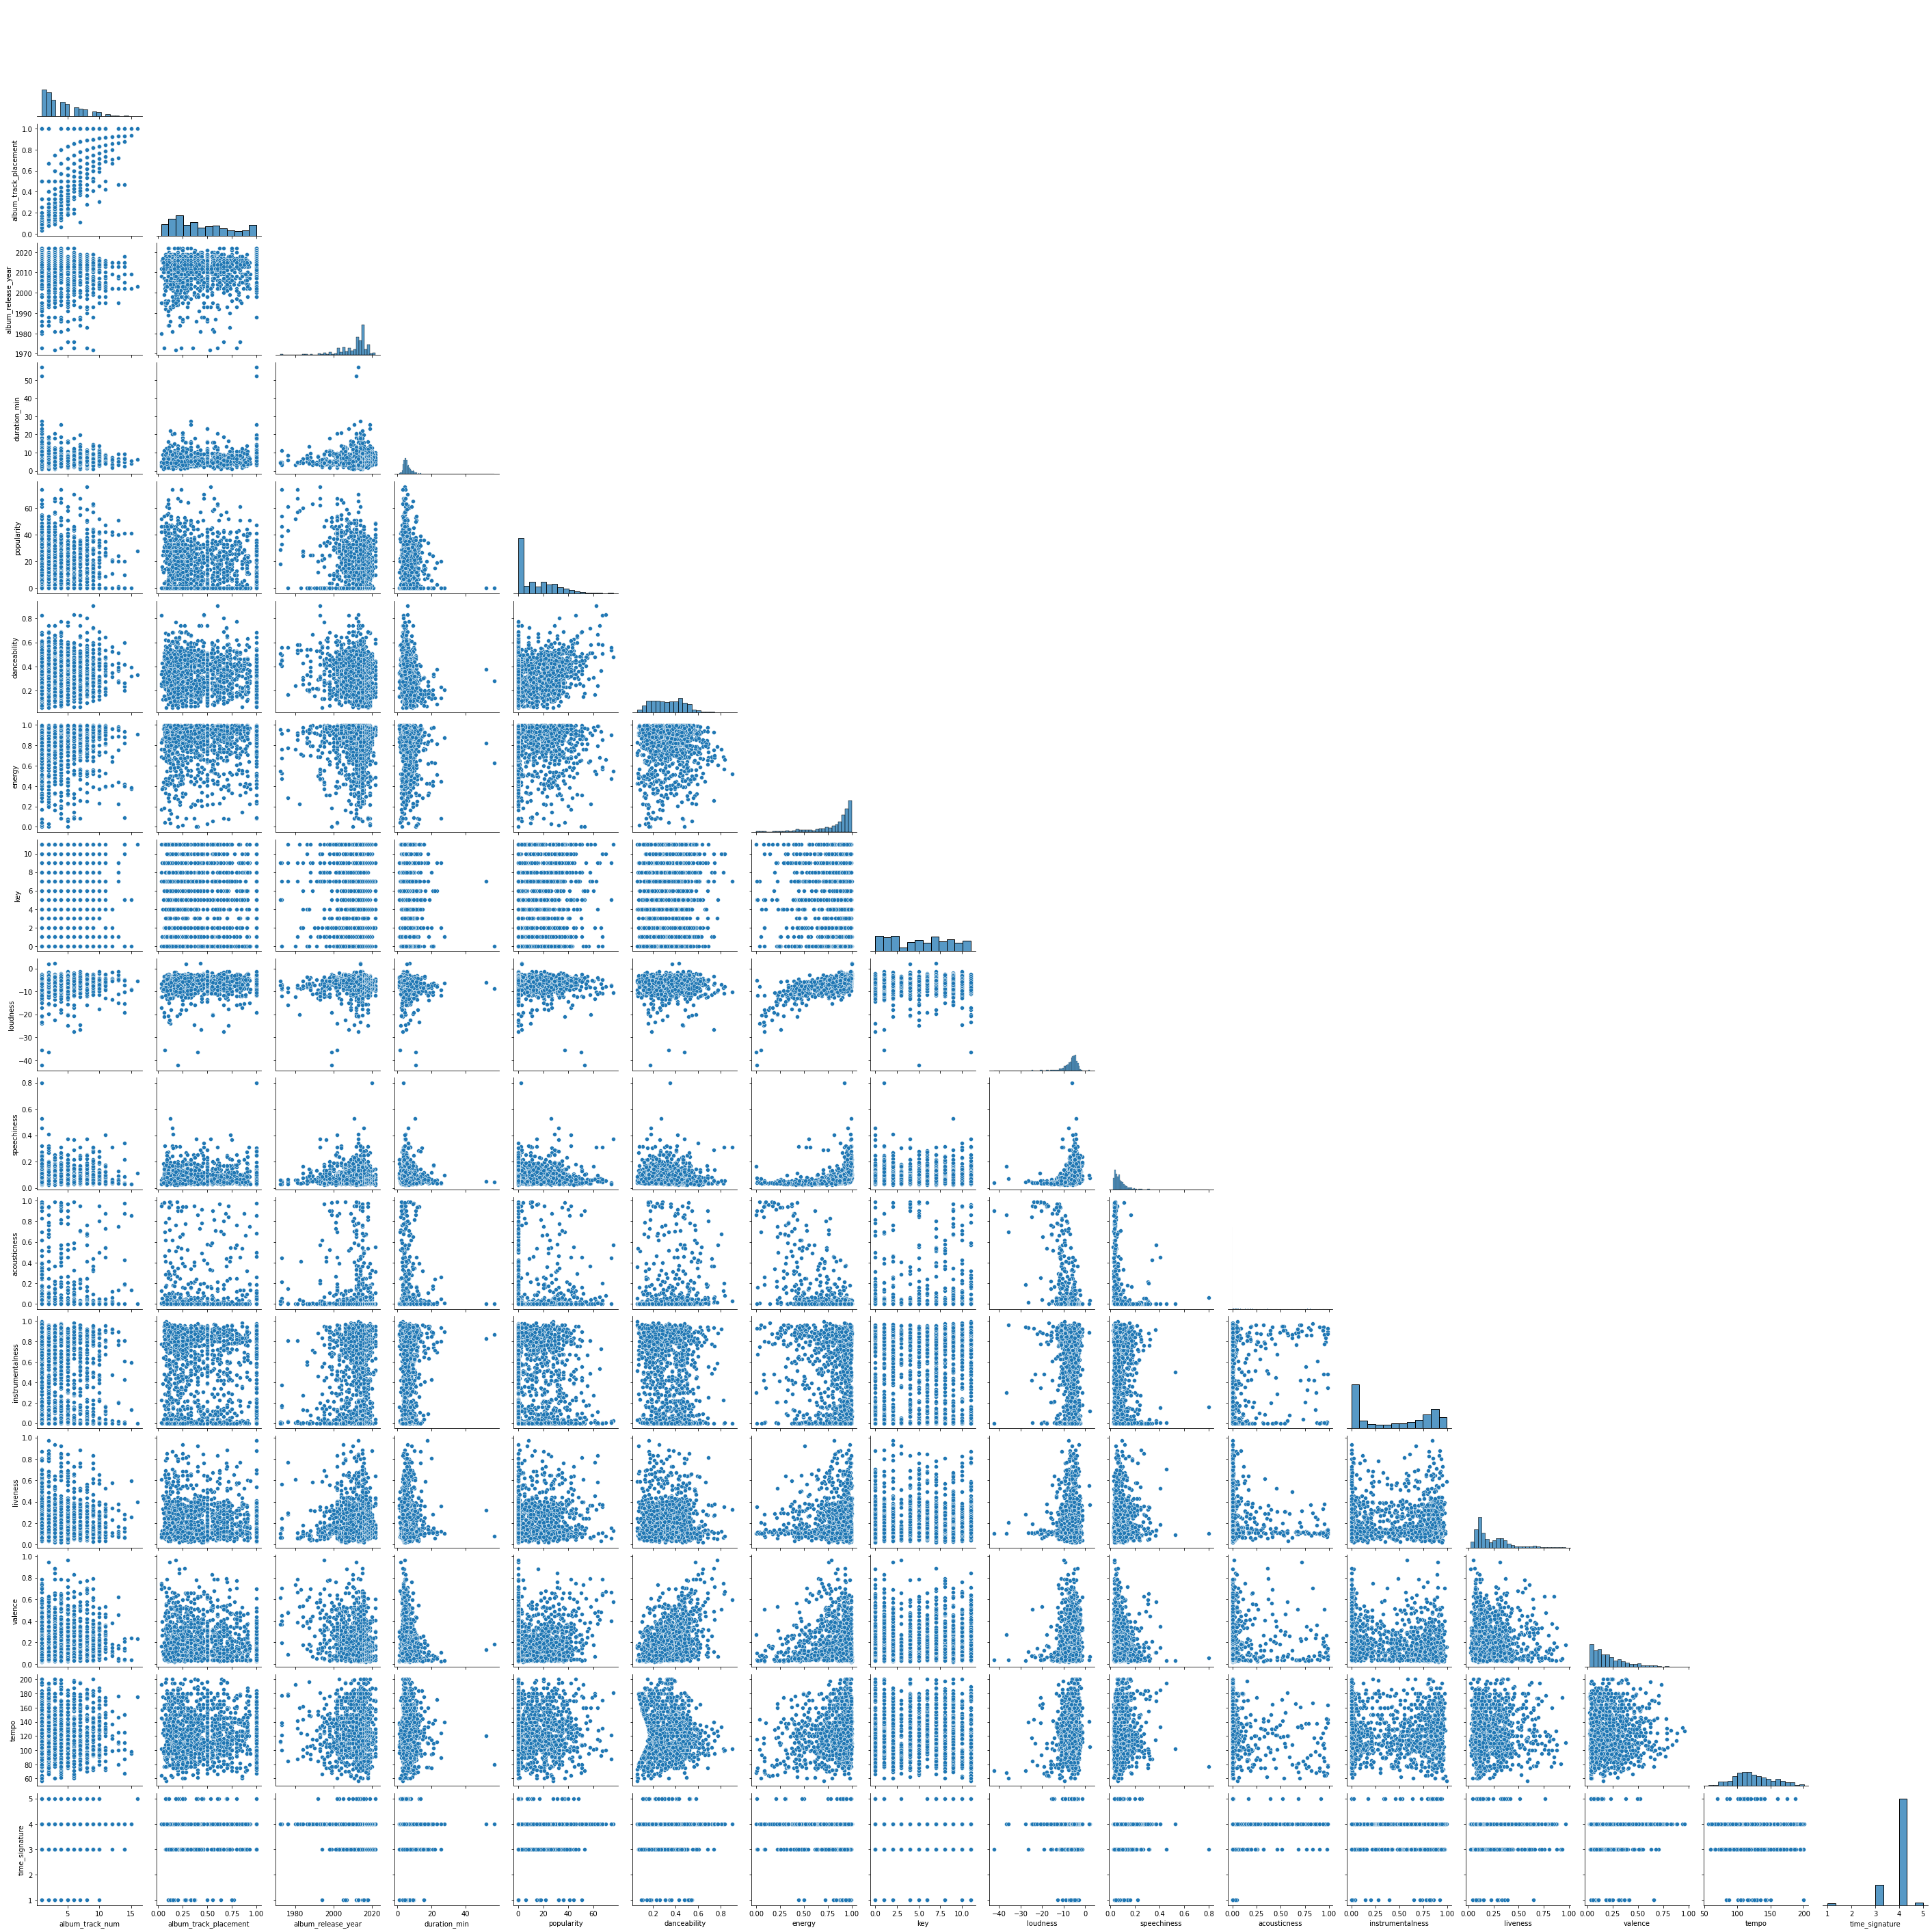

In [22]:
sns.pairplot(df[numerical], corner=True)
plt.show()

# Clustering

## Background on K Means
I use K-Means clustering to cluster the data. For some fixed number of clusters k, k-means begins by picking random points to be cluster centers, then assigning each sample in the data to the cluster with the nearest center. The centers of each cluster are re-computed based on the assignment, then points are reassigned to the cluster with the nearest recently computed center. This process of computing cluster centers and reassigning points repeats until some convergence condition is met, like the sum of squared distances within clusters falling below some level. 

Since k-means clustering uses distances to compute cluster assignments, each feature must be on the same scale as every other. To scale, I transform each feature such that mean = 0 and standard deviation = 1. 

K-means is unsupervised, meaning it does not use labeled data to train. This means that we cannot compare predicted cluster values to known values to choose the number of clusters k. Instead, I use the elbow method. For the elbow method, first you choose some range of k values to try. You run k-means for each and plot the sum of squared distances within clusters against the k values. Ideally, the plot should have what looks more or less like an "elbow." For values of k larger than the value at the elbow, the sum of squard distances should decrease much more slowly than it increases for smaller values. The number k should be at (or at least near) that elbow.

My ultimate goal is for the clusters to be human interpretable. Therefore, I use the elbow method as a guideline and will deviate to the extent it benefits the interpretability of the clusters.

## Feature Selection Justification
Going forwards, I ignore categorical features and popularity. I ignore the categorical features as they have no meaningful means or distances between values. I ignore the popularity feature simply because that leads to better clustering.

In [23]:
analysis_features = ['duration_min', 'danceability', 'key', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [24]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df[analysis_features].values)

100%|██████████| 19/19 [00:06<00:00,  2.85it/s]


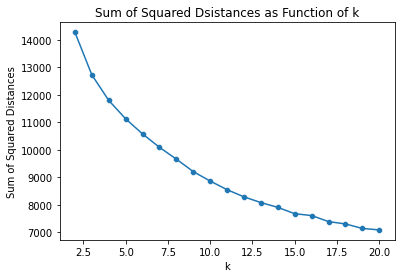

In [25]:
k_range = np.linspace(2, 20, num=19, dtype=int)
ssd = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)

sns.scatterplot(x=k_range, y=ssd)
sns.lineplot(x=k_range, y=ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Sum of Squared Dsistances as Function of k')
plt.show()

This plot is perhaps not the most ideal. I choose k=3 as the number of clusters

In [26]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_

# Analyzing Clusters
Here the two goals are 1) figure out of the cluster assignments are reasonable and 2) determine some human interpretable label for each cluster.

## Visualizing Clusters
The clusters can be visualized using a dimensional reduction technique, here, princiapl components analysis (PCA). Principal components analysis finds vectors pointing in directions of maximum variance in the data, each vector orthogonal to all the other vectors. These vectors are the principal components. To visualize the clusters, the data is plotted projected onto the first two principal components. As a general matter, if either the PCA has not been particularly effective or the number of clusters has not been chosen particularly well, there will be a high degree of overlap between the clusters.

In [27]:
pca = PCA()
df_scaled = ss.fit_transform(df[analysis_features].values)

pca_vals = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_vals, columns=[f'pc_{i+1}' for i in range(len(analysis_features))])


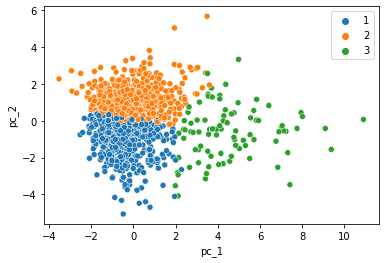

In [28]:
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=cluster_labels+1, palette='tab10')
plt.show()

We can see from the above that the clusters look nicely separated when plotted on the principal coordinates. However, one cluster clearly has fewer members than the other two. We can also guess based on the above plot that the smaller cluster is likely to be an "outlier" cluster and the larger clusters will be more similar to each other than either is to the smaller cluster.

## Summary Statistics
I plot the mean and standard deviation for each feature broken out by clusters to get an initial idea of whether the clusters are identifying meaningfully (to the human interpreter) distinct groups of songs

In [29]:
# Add cluster labels to original dataframe
df['cluster_labels'] = cluster_labels +1

Going forward, it will be convenient to refer to the clusters as something like the small, middle-sized or large cluster, rather than just the integer labels. I write code to do this here.

In [30]:
def get_clusters_by_size(df):
    '''
    Identifies the labels associated with the smallest, medium size, and largest cluster, assuming k=3.
    Parameter: df, a dataframe with the feature cluster_labels taking on 3 unique values.
    Returns: sorted_labels, a list of ints, each a cluster label, sorted by smallest to largest cluster
    '''
    # Find clusters in a way that can identify the smallest, largest, and middle sized one across different runx of the notebook
    cluster_lengths = [len(df[df['cluster_labels']==i]) for i in range(1,k+1)]
    dummy_labels = [i for i in range(1, k+1)]
    sorted_zip = sorted(zip(dummy_labels, cluster_lengths), key=lambda x: x[1])
    sorted_labels = [x[0] for x in sorted_zip]
    return sorted_labels

sorted_cluster_labels = get_clusters_by_size(df)
int_to_string = {sorted_cluster_labels[0]:'Smallest', sorted_cluster_labels[1]:'Middle Sized', sorted_cluster_labels[2]: 'Largest'}
cluster_label_string_labels = df['cluster_labels'].map(int_to_string)

I will plot the summary statistics for each feature broken out by clusters. To do this, first I calculate the mean and standard deviation for each feature for each cluster. I also check the number of members in each cluster.

In [31]:
df_summ_stats = df[analysis_features + ['cluster_labels']].groupby(cluster_label_string_labels).agg(['mean', 'std', 'count'])
df_summ_stats

duration_min                 danceability                  \
                       mean       std count         mean       std count   
cluster_labels                                                             
Largest            5.139446  1.664789   654     0.427941  0.114228   654   
Middle Sized       7.308250  4.548867   631     0.239764  0.096838   631   
Smallest           5.792762  3.679332    93     0.363852  0.181199    93   

                     key                    energy  ... valence       tempo  \
                    mean       std count      mean  ...   count        mean   
cluster_labels                                      ...                       
Largest         5.238532  3.665323   654  0.870636  ...     654  124.334965   
Middle Sized    5.101426  3.473599   631  0.852622  ...     631  126.468908   
Smallest        5.580645  3.825892    93  0.345626  ...      93  106.636559   

                                time_signature                 cluster_labels  \
                      std count           mean       std count           mean   
cluster_labels                                                                  
Largest         27.709113   654       3.906728  0.438063   654            1.0   
Middle Sized    30.054456   631       3.702060  0.627400   631            2.0   
Smallest        30.673231    93       3.903226  0.418707    93            3.0   

                           
                std count  
cluster_labels             
Largest         0.0   654  
Middle Sized    0.0   631  
Smallest        0.0    93  

[3 rows x 39 columns]

We can confirm above that one cluster is substantially smaller than the other two.

With the summary statistics calculated, we can plot them for each feature below. Having a key would crowd the plots, so note the mean is in blue and the standard deviation is in orange.

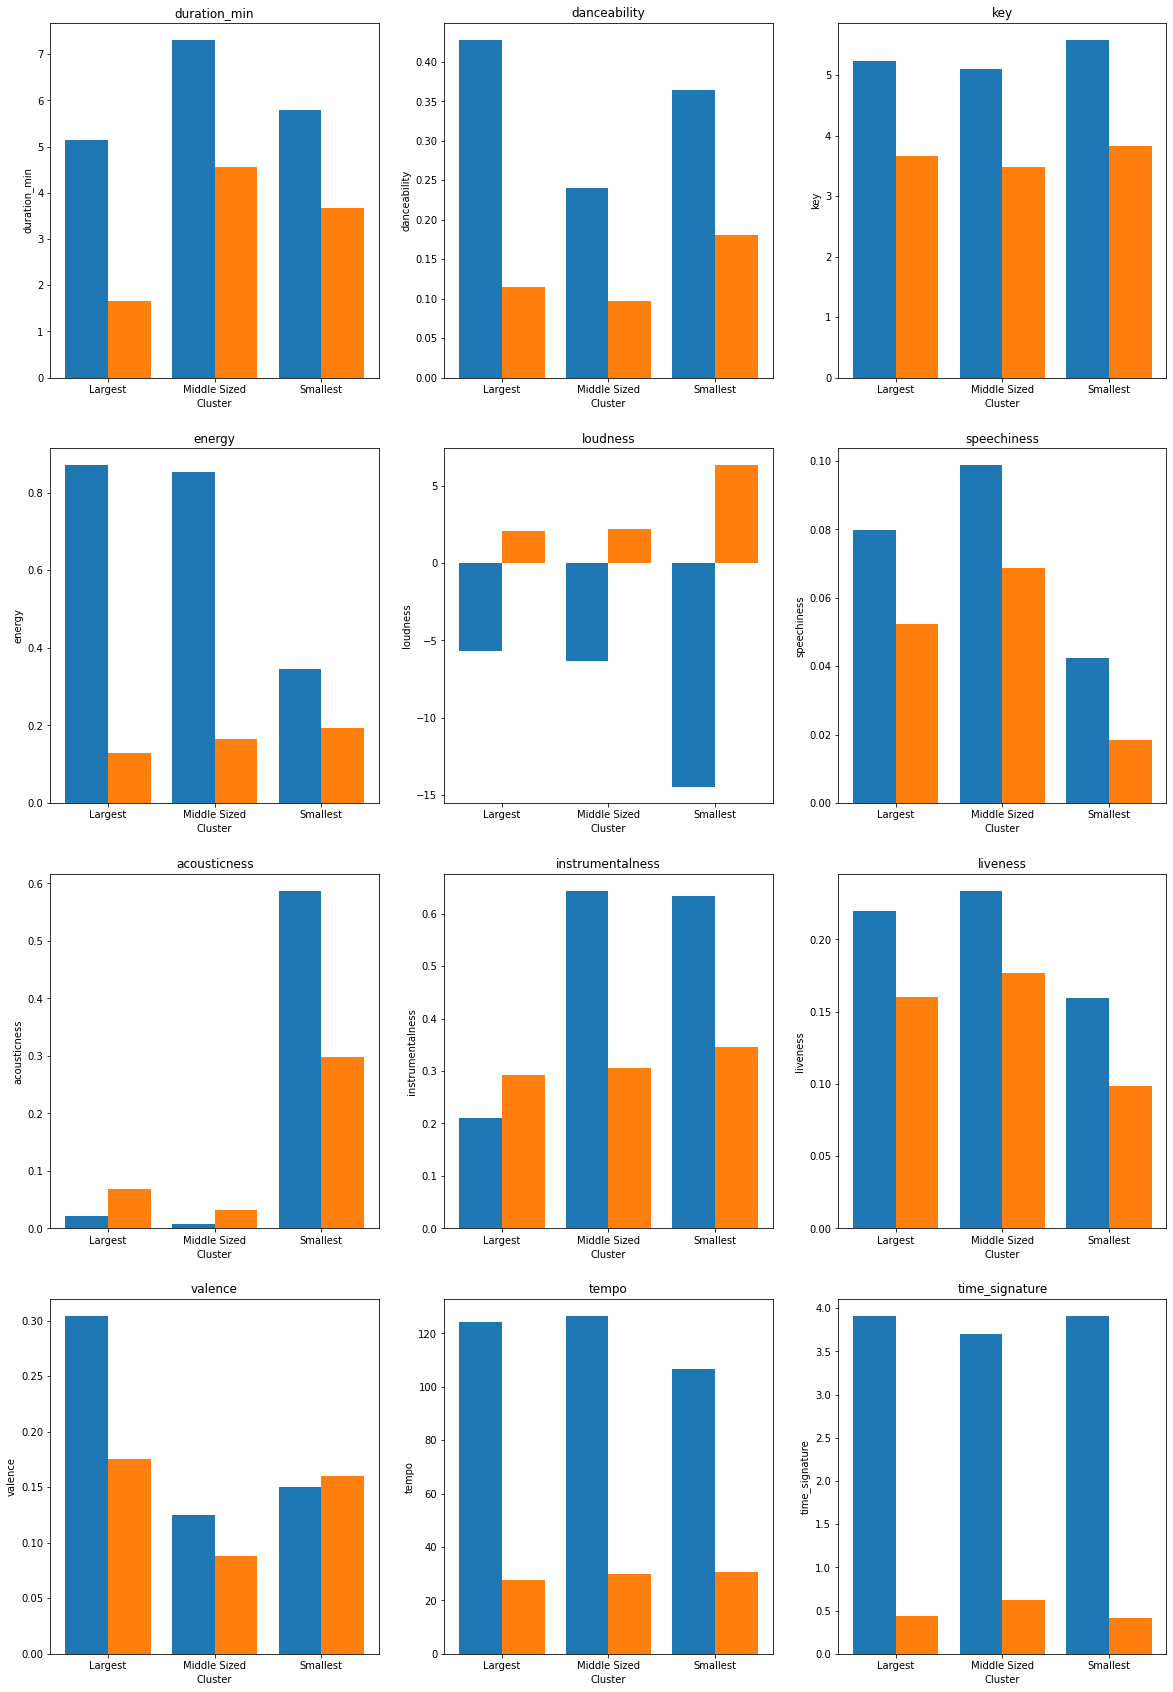

In [32]:
fig, axes = plt.subplots(4, 3, figsize=(20,30))
clusters = np.array(range(1, k+1))
#string_clusters = [int_to_string_label[cluster] for cluster in clusters]
for feature, ax in zip(analysis_features, np.ravel(axes)):
    if feature in numerical:
        # Plot means
        ax.bar(x=clusters - 0.2, height=df_summ_stats[feature]['mean'], width=0.4)

        # Plot standard deviations
        ax.bar(x=clusters + 0.2, height=df_summ_stats[feature]['std'], width=0.4)
        
    elif feature in boolean:
        # Plot means
        ax.bar(x=clusters, height=df_summ_stats[feature]['mean'], width=0.4)

    if 'year' in feature:
        ax.set_ylim(1950, 2022)

    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.set_xticks(sorted_cluster_labels)
    ax.set_xticklabels([int_to_string[label] for label in sorted_cluster_labels])
    #ax.set_xticklabels(string_clusters)

for i, ax in enumerate(np.ravel(axes)):
    if i > len(analysis_features)-1:
                ax.axis('off')

plt.show()

To avoid cluttering up the plots with legends, note that means blue and the standard deviations are in orange. For the album release year, the height of the y-axis is in a range beyond the size of the standard deviations, but they are relatively small for each feature. For the boolean features, standard deviations are not helpful, thus not plotted.

By examining the above chart - and noting we are not testing for differences between means and that we have disimilar cluster membership levels - we have more evidence that the clustering has found songs that are distinct in the distribution of their features, particularly when looking at features like danceability, speechiness or valence. It is also worth noting that there are some substantially large standard deviations in some of the features, notably in features like acousticness and popularity, there are standard deviations higher than the associated means. Further, we should be come more convinced that the smaller cluster is very dissimilar from the other two.

Specifically, we can make the following claims about the mean of each feature for each cluster. Note that when using terms like "most," "least," "quietest," etc. I am referring to only the mean - there is variation within each feature for each cluster, which will be plotted below.

<ins>**Largest Cluster**</ins>
* Most danceable
* Lowest mean probability of being instrumental
* Highest mean valence

<ins>**Middle-Sized Cluster**</ins>
* Longest mean duration
* Least danceable
* Highest mean probability of being speech - still only 0.10
* Lowest valence

<ins>**Smallest Cluster**</ins>
* Lowest energy
* Quietest
* Highest mean probability of being acoustic - by a lot
* Lowest mean probability of being speech 
* Slowest tempo

In [33]:
filename = 'trained_kmeans.sav'
pickle.dump(kmeans, open(filename, 'wb'))

## Variable Distributions and Relationships Within Clusters
We can now plot similar plots to those in the initial data analysis, except this time, we can break songs out by cluster assignment.

## Univariate Distributions

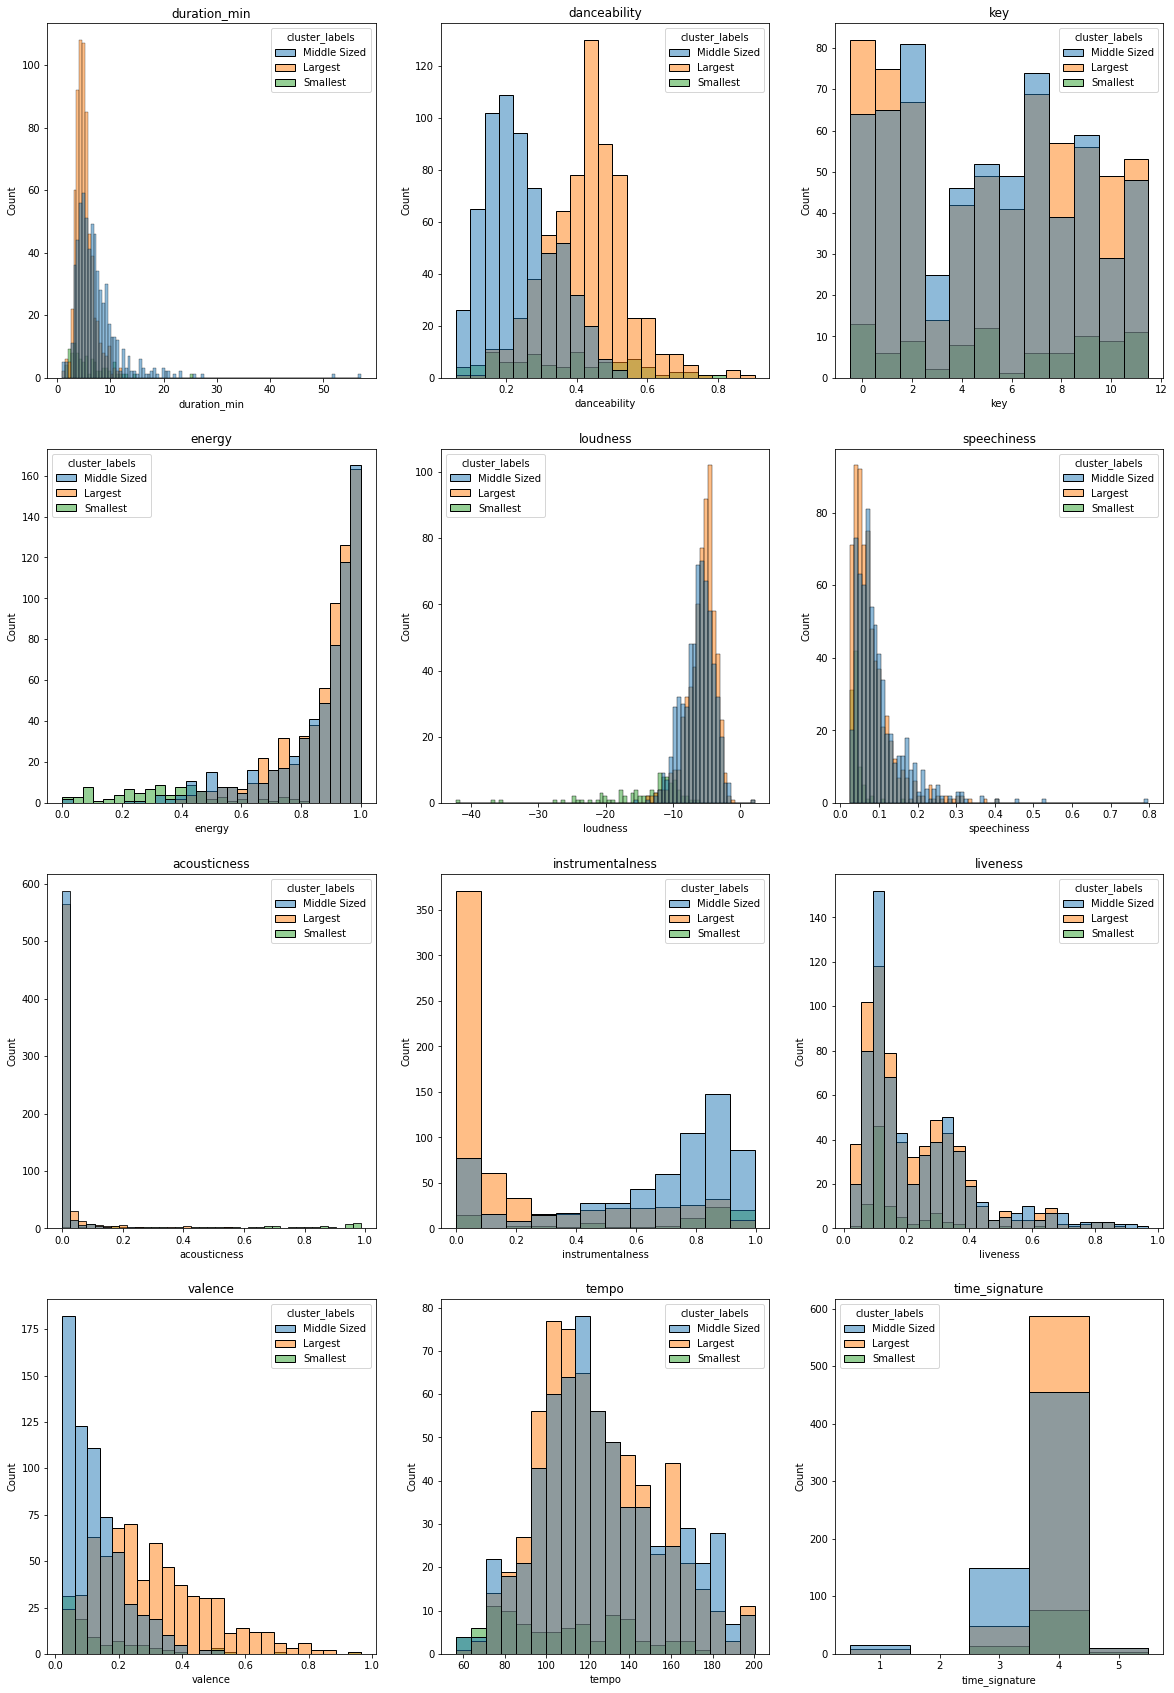

In [34]:
fig, axes = plt.subplots(4, 3, figsize=(20,30))

for col, ax in zip(analysis_features, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, hue=cluster_label_string_labels, discrete=True, ax=ax, palette='tab10')
    elif col == 'acousticness':
        sns.histplot(data=df, x=col, bins=int(np.sqrt(len(df))), hue=cluster_label_string_labels, ax=ax, palette='tab10')
    else:
        sns.histplot(data=df, x=col, hue=cluster_label_string_labels, ax=ax, palette='tab10')
    ax.set_title(col)

for i, ax in enumerate(np.ravel(axes)):
    if i > len(analysis_features)-1:
                ax.axis('off')
plt.show()

From the above, we can see that features do not only differ when looking at the mean and standard deviation. From the above, we see that songs in different clusters are distributed entirely disimilarly beyond these basic summary statistics. Danceability, instrumentalness, and valence provide the most obvious examples here. It is worth noting that the smallest cluster, here in green, more often has features distributed differently from both of the larger clusters than either have features distributed differently from each other. This could pose human interpretability problems, where it is very easy to determine how the small cluster is different from the larger one but difficult to determine how the larger clusters differ from each other, without referring back to distributions and summary statistics.

## Relationships between Features Within Clusters

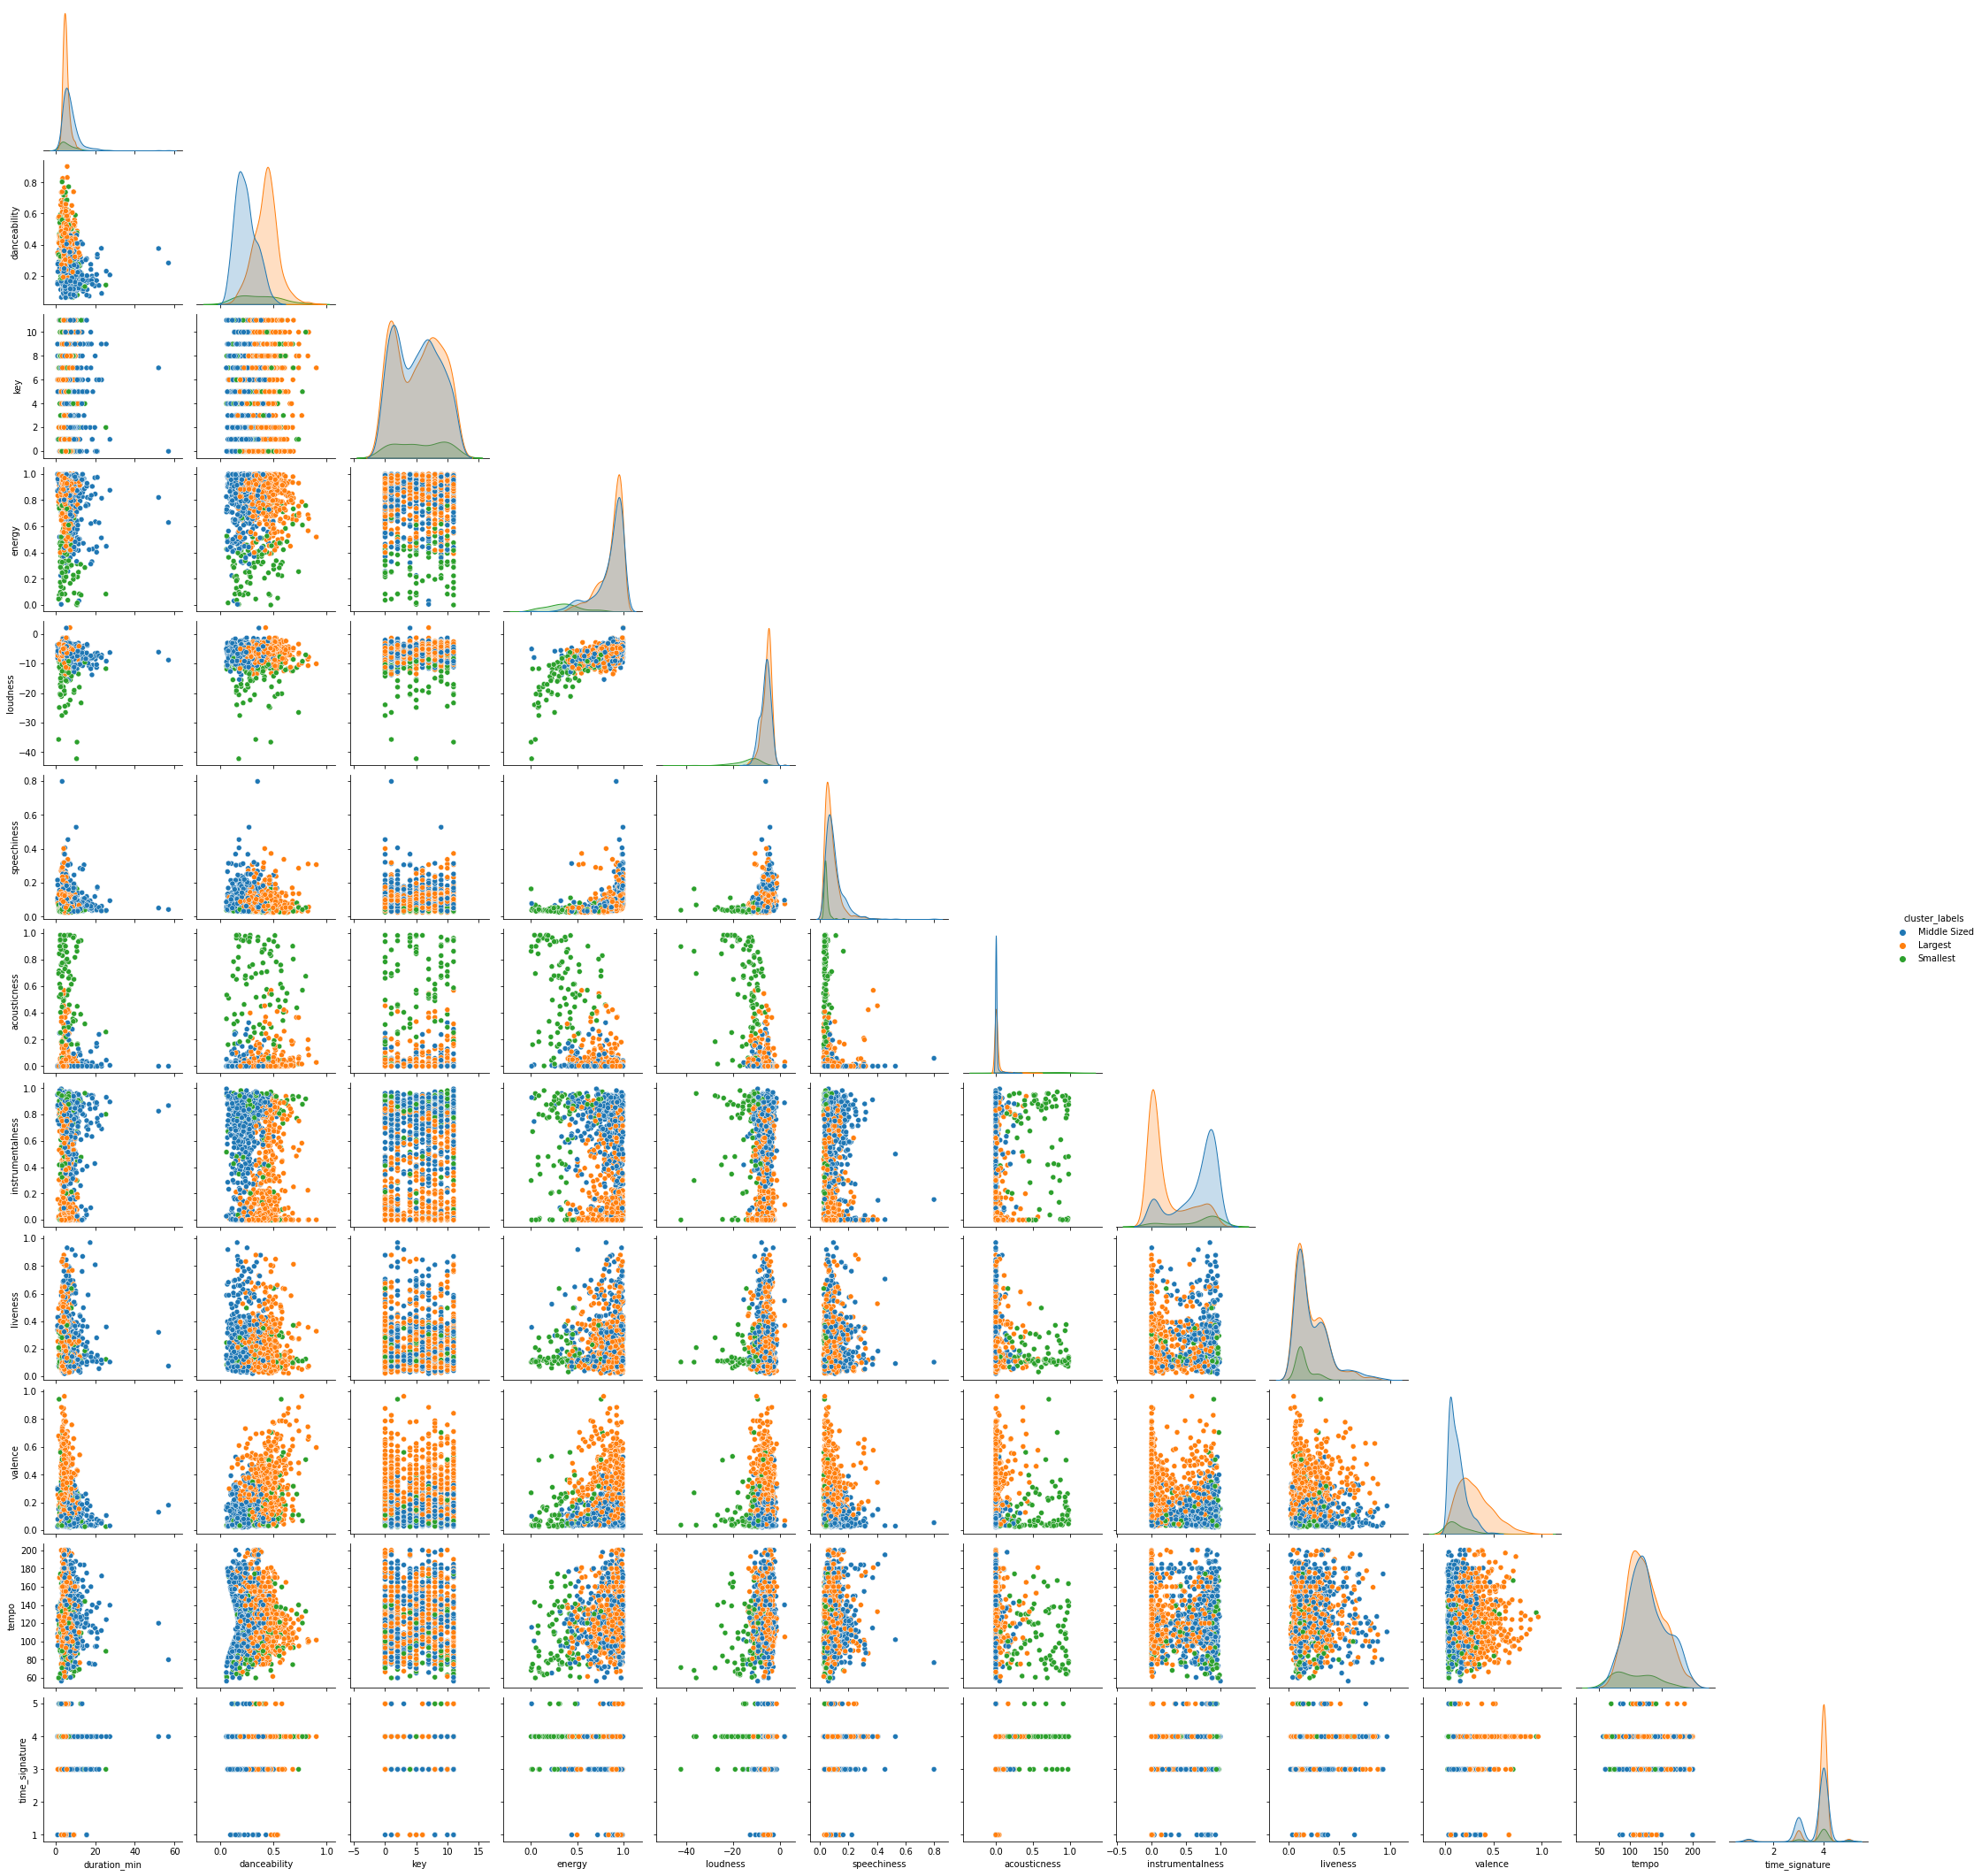

In [35]:
sns.pairplot(pd.concat([df[analysis_features], cluster_label_string_labels], axis=1), hue='cluster_labels', corner=True, palette='tab10')
plt.show()

Beyond the kernel density estimations on the diagonal which just provide evidence for what we learned from the histograms in a less convincing manner due to the estimation, this plot allows us to see how features interact with each other within clusters.

## Examining Songs within Clusters
I print 20 songs from each cluster to get a further idea of what songs are in which cluster. To keep the output consistent between runs, I first identify the numerical label of each cluster by size. The k-means algorithm will identify these clusters consistently, but it may label them differently each time the model is retrained.

In [36]:
print(f'20 Random Songs from Cluster {sorted_cluster_labels[0]}, the smallest cluster')
df[df['cluster_labels'] == sorted_cluster_labels[0]][song_info].sample(frac=1, random_state=1234).head(20)

20 Random Songs from Cluster 3, the smallest cluster


track_name  \
1148  Symphony No. 9 in E Minor "From The New World"...   
1295                                 Test Pattern #0111   
1290                                           Twinkler   
1136  Lamentatio I for Holy Wednesday for Bass, Two ...   
1095                                             Origin   
545                                    La guerre sacrée   
347                    Fratres, für Violine und Klavier   
1097                                         Arcenstone   
973   Missa omnium sanctorum, ZWV 21: Gloria. Quonia...   
602                                            Monument   
483                                           Reverence   
215                                           Für Alina   
539                                       Mono No Aware   
1167                         The Real Song For The Deaf   
620               Miserere in C Minor Psalm 50, ZWV. 57   
862                                Just Shy of Survival   
216   Spiegel im Spiegel - Version for Violin and Piano   
1269                                                III   
1151              Ouverture: I. Grave - Allegro - Grave   
1180                                      Mosquito Song   

                       artist  \
1148           Antonín Dvořák   
1295              Ryoji Ikeda   
1290                 Baroness   
1136       Jan Dismas Zelenka   
1095         Keep Of Kalessin   
545        The Red Army Choir   
347          Kayako Bruckmann   
1097                Summoning   
973        Jan Dismas Zelenka   
602                  Röyksopp   
483           Countless Skies   
215                 Arvo Pärt   
539              Agent Fresco   
1167  Queens of the Stone Age   
620        Jan Dismas Zelenka   
862           House of Wolves   
216                 Arvo Pärt   
1269                    KAUAN   
1151       Jan Dismas Zelenka   
1180  Queens of the Stone Age   

                                             album_name  
1148                          František Stupka conducts  
1295                                       Test Pattern  
1290                                     Yellow & Green  
1136  Zelenka: The Lamentations of Jeremiah The Prop...  
1095                                           Kolossus  
545   Chants et Marches de la Grande Guerre Patrioti...  
347                            Pärt: Spiegel im Spiegel  
1097                                         Lost Tales  
973   Jan Dismas Zelenka: Missa omnium sanctorum, ZW...  
602                                         Do It Again  
483                                     Countless Skies  
215                                    Arvo Pärt: Alina  
539                            Destrier (Bonus Edition)  
1167                                 Songs For The Deaf  
620             Zelenka: De Profundis, Misere & Requiem  
862                                 Daughter of the Sea  
216                                    Arvo Pärt: Alina  
1269                                              Pirut  
1151                          Zelenka: Orchestral Works  
1180                                 Songs For The Deaf

I find this cluster particularly impressive. It's pretty clearly identified slower, quieter, dronier tracks with a large portion of the songs listed above being non-metal tracks. In a sense these are "outliers" when compared to the rest of my liked songs - although they will not be considered outliers for the sake of analysis as they do reflect my musical preferences.

In [37]:
print(f'20 Random Songs from Cluster {sorted_cluster_labels[1]}, the middle-sized cluster')
df[df['cluster_labels'] == sorted_cluster_labels[1]][song_info].sample(frac=1, random_state=1234).head(20)

20 Random Songs from Cluster 2, the middle-sized cluster


track_name                  artist  \
1160  You Don't Have To Be Afraid Anymore               Vehemence   
428                          Monolithe IV               Monolithe   
1043                   A-Life Omega Point                  Wormed   
638                          The Forsaken     Mors Principium Est   
819                          Temple Doors            Crypt Sermon   
296                    Malediction Murder                    Dawn   
728                             Trisagion        Erebus Enthroned   
803             Through Infectious Waters               Draconian   
286                          Ethica Odini                Enslaved   
440                            Liberation  Devin Townsend Project   
633                              I Am War     Mors Principium Est   
873                             Deep Cold         Omnium Gatherum   
50            I. Woe Regains My Substance                  Mizmor   
1015           Blood Sugar - Original Mix                Pendulum   
291                                  Dirt           S U R V I V E   
189               Overwriting Incorporate            Anamanaguchi   
1212                        Cosmic Cortex                  Vektor   
1028                           Persepolis             Septicflesh   
1195                      A Curse of Baal       Intestine Baalism   
223                          This Is Fire              Dyscarnate   

                                             album_name  
1160                           Helping the World to See  
428                                        Monolithe IV  
1043                                            Krighsu  
638                                 Dawn of the 5TH Era  
819                                   Out of the Garden  
296   Slaughtersun (Crown Of The Triarchy) (Re-Issue...  
728                                   Temple Under Hell  
803                                    The burning Halo  
286                                 Axioma Ethica Odini  
440                                            Epicloud  
633                                 Dawn of the 5TH Era  
873                                   New World Shadows  
50                                                 Yodh  
1015                                   Hold Your Colour  
291                                              RR7349  
189                                               [USA]  
1212                                    Outer Isolation  
1028                                          Communion  
1195                            Banquet In The Darkness  
223                                With All Their Might

These songs are often dark or long. This is not universal - the Anamanaguchi song is neither, for example.

In [38]:
print(f'20 Random Songs from Cluster {sorted_cluster_labels[2]}, the largest cluster')
df[df['cluster_labels'] == sorted_cluster_labels[2]][song_info].sample(frac=1, random_state=1234).head(20)

20 Random Songs from Cluster 1, the largest cluster


track_name  \
356                                       Yellow Nights   
1193                               Songs from the North   
829                                        Head Up High   
1250                              Hide In the Fairytale   
512                                       What the Fuck   
984                                         Death Of Me   
1119                                            Ingimar   
744                                In Flagrante Delicto   
533                                                1985   
795          Only the Broken Hearts (Make You Beatiful)   
659                                 Through The Element   
1102                                       The Haunting   
469                                    The Odious Tides   
547   C.R.E.A.M. (Cash Rules Everything Around Me) (...   
1244                                        Apparitions   
627                            Flames Of The Silver Sea   
1256                         Escape from Midwich Valley   
1300                                The Atlantean Kodex   
629                           Sweet Lilith Of My Dreams   
1211                              Tetrastructural Minds   

                       artist  \
356              Agent Fresco   
1193          Swallow The Sun   
829                  Firewind   
1250                Theocracy   
512     Rise Of The Northstar   
984                    Gojira   
1119                      HAM   
744            Anaal Nathrakh   
533                     Haken   
795            Sonata Arctica   
659                   Noumena   
1102                Avantasia   
469            Dawn Of Azazel   
547              Wu-Tang Clan   
1244       The Gaslamp Killer   
627                      Scum   
1256           Carpenter Brut   
1300          Atlantean Kodex   
629   Eternal Tears Of Sorrow   
1211                   Vektor   

                                             album_name  
356                               A Long Time Listening  
1193                   Songs from the North I, II & III  
829                                     The Premonition  
1250                                As the World Bleeds  
512                                             Welcame  
984                                            The Link  
1119                              Svik, harmur og dauði  
744                                The Whole of the Law  
533                                            Affinity  
795                                Stones Grow Her Name  
659                                     Anatomy of Life  
1102                        Ghostlights (Bonus Version)  
469                               The Tides of Damocles  
547   Enter The Wu-Tang (36 Chambers) [Expanded Edit...  
1244                                       Breakthrough  
627                             Purple Dreams &........  
1256                                            Trilogy  
1300                                   The Golden Bough  
629                             Before The Bleeding Sun  
1211                                    Outer Isolation

These songs are generally shorter or more upbeat than the songs from the middle cluster

### Artists and Albums Unique to One Cluster
Useful to interpreting the clusters will be to find the artists and albums that are in one cluster but not the other cluster. I find these and print them out. For brevity, rather than printing all of the values unique to a cluster, I print a relatively small number. However, I did personally examine all of the values unique to each cluster.

#### Artists only Found Within one Cluster

In [39]:
def unique_to_cluster(feature):
    '''
    Finds either the artists or album names that are unique to each cluster
    Parameter: feature, either 'artist' or 'album_name'
    Returns unique_feature_vals, a dictionary where keys are cluster labels and values are lists of unique feature values.
    '''
    unique_labels  = df['cluster_labels'].unique()
    unique_feature_vals = {cluster:[] for cluster in unique_labels}

    for cluster in unique_labels:
        other_clusters = [i for i in unique_labels if i != cluster]
        unique_values = df[df['cluster_labels'] == cluster][feature].unique()

        # Find unique values in other clusters
        other_cluster_values = []
        for i in other_clusters:
            other_cluster_values.extend(df[df['cluster_labels'] == i][feature].unique())

        # Find values unique to cluster under consideration
        for value in unique_values:
            if value not in other_cluster_values:
                unique_feature_vals[cluster].append(value)
    return unique_feature_vals

def print_unique_cluster_info(cluster, artist_or_album):
    '''
    For each cluster, print 50 of either the unique artists or albums for a cluster.
    Parameters: cluster, the integer label of the cluster for which to print unique values
                artist_or_album, either 'artist' or 'album_name' the string name of the feature for which to find unique values
    '''
    no_overlap = unique_to_cluster(artist_or_album)
    if artist_or_album == 'artist':
        feature_name = 'artists'
    else:
        feature_name = 'albums'
    num_unique_to_cluster = len(no_overlap[cluster])
    
    # Print the minimum of 50 unique samples or all of the samples in cluster
    sizes = ['smallest', 'middle-sized', 'largest']
    for i, label in enumerate(sorted_cluster_labels):
        if cluster == label:
            print(f'The following {min(50, len(no_overlap[cluster]))} {feature_name} are only in the {sizes[i]} cluster:')
            print(', '.join(no_overlap[cluster][:min(50, len(no_overlap[cluster]))]))
        


for cluster in clusters:
    print_unique_cluster_info(cluster, 'artist')
    print('\n')

The following 50 artists are only in the largest cluster:
Stratovarius, Aim, DJ Shadow, Rainbow, Sonata Arctica, Starkill, Quo Vadis, Dark Tranquillity, Dawnbringer, Animals As Leaders, Death Angel, Cynic, Ancient Bards, Voyager, Witchcraft, Cannibal Ox, The Besnard Lakes, Car Bomb, Cory Henry, Brian Eno, CHVRCHES, Sleigh Bells, Hällas, Sarastus, Gatekeeper, Home, Blind Guardian, Avantasia, Earth Ship, Carcass, Nullingroots, Noctem, iamamiwhoami, Hinayana, Ajattara, Ashbringer, Nocturnus, Leprous, Forest Of Fog, Twilight Force, Eternal Tears Of Sorrow, Harmony, Arjen Anthony Lucassen's Star One, The Meads Of Asphodel, Liege Lord, Below, Manes, Angel Witch, Kavinsky, Junius


The following 50 artists are only in the middle-sized cluster:
Malist, Lightning Bolt, At The Gates, Skyfire, Trespasser, Be'lakor, Alcest, Ancient Ascendant, Giant Squid, In Vain, Mizmor, Vallenfyre, Procession, Astronoid, Blackbraid, Artificial Brain, Sulphur Aeon, Thrawsunblat, Latitudes, Cities of the Plain, Ge

These artists generally track with how the clusters have been characterized. The largest song contains artists that make upbeat, relatively positive music.  The artists in the middle-sized cluster make songs that tend to be if not darker, at least more atmospheric in the sense of being less rhythmically driven while still being high energy relative to the third cluster. The third cluster contains the "outliers," music that is classical, drony, purely atmospheric (as in bordering on or actually ambient), etc. 

#### Albums only Found Within one Cluster

In [40]:
for cluster in clusters:
    print_unique_cluster_info(cluster, 'album_name')
    print('\n')

The following 50 albums are only in the largest cluster:
Argent Moon - EP, Nemesis (Special Edition), Drum Machines & VHS Dreams, Endtroducing (Deluxe Edition), Rising, Nemesis, Reckoning Night, Fires of Life, Defiant Imagination, The Gallery, Darkness Silence Mirror Flame, Iteration, Into the Lair of the Sun God, Parrhesia, Advance To The Fall, Humanicide, On Strange Loops, Focus, Origine (The Black Crystal Sword Saga, Pt. 2), Colours in the Sun, Skyforger, The Conjurer, Our Pathetic Age, Blade of the Ronin (Deluxe Edition), A Coliseum Complex Museum, Play & Play: B Sides, ...And Death Said Live, Love Will Find a Way, Here Come The Warm Jets, Every Open Eye (Special Edition), The Bones of What You Believe, Reign of Terror, Excerpts from a Future Past, II-Toinen Tuleminen, Vigilance, Before the Night, Beyond The Red Mirror, Ghostlights (Bonus Version), The Metal Opera, Pt. I, Withered, Venenare, Surgical Steel, Into the Grey, The Black Consecration, Stellar Sparks, Bounty, Order Divine

This mirrors the artists that are unique to each cluster.

## Interpretation
The clusters are human fairly interpretable.

The smallest cluster contains music that tends to be quiet or low energy - ambient, drone, classical, acoustic singer/songwriter music, etc.

The second two clusters both contain higher energy music, but they can be distinguished as follows.

The middle-sized cluster contains music that tends to be longer and darker.

The large cluster contains music that is more upbeat or rhythmically driven.

# Predictive Analysis
I would like be able to predict why I might like new songs. To do this, I train a classifier and adopt a simple anomaly detection method.

## Classifier
I train a support vector machine with a linear kernel to classify songs. The rationale for this is simple. Support vector machines classify points by where they lie with respect to separating hyperplanes. Just looking at the plot of the clusters on the principal components above, it would appear that you could draw straight lines on the plot and successfully separate most of the points into their respective clusters. Considering that more principal components will account for more information in the dataset, it is reasonable to conclude that linear hyperplanes in several dimensions will divide up the clusteres even better than straight lines in two dimensions.

In [41]:
X = df[analysis_features]
y = df['cluster_labels']


# Create training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.33, stratify=y)

# Scale the data
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train.values)
x_test_scaled = ss.transform(x_test.values)

# PCA
pca = PCA(random_state=123)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

### Cross-Validation
Support vector machines have a regularization hyperparameter, C. C controls how much the model is penalized for misclassifying points in the dataset. For large values of C, misclassification is penalized more and for small values, it is penalized less. Since C is a hyperparameter, it will not be optimized when the model is trained. We must choose the value ourselves.

I choose the value using a grid search. For a list of values taken by a single hyperparameter, a grid search evaluates the performance of the model at each hyperparameter. It evaluates the performance using cross validation. Cross validation is motivated as follows. We want to see how our support vector machine performs on unseen data given the value of C. We cannot train on all of the training data and evaluate on the test data to do this, since that would contaminate the data. So what we do instead is divide the training set into multiple parts called "folds;" here we use five folds. We train the model on four of the folds and test on the fifth. And we repeat this process until all five folds have been used as test data. We average the metric used to evaluate the data, smoothing out any overly optimistic or pessimistic results caused by the data used to train the model. Again, we do this cross validation model for each value in our hyperparameter "grid," then we choose the hyperparameter value associated with the highest average evaluation metric score.

In [42]:
C_range = np.logspace(0.001, 2, base=10)
params = {'C':C_range}

svc = SVC(kernel='linear', random_state=123)
gs = GridSearchCV(estimator=svc, param_grid=params)

gs.fit(x_train_pca, y_train)
gs.best_estimator_, gs.best_score_

svc = gs.best_estimator_
svc

SVC(C=29.488525767503155, kernel='linear', random_state=123)

## Training the Support Vector Machines

In [43]:
svc.fit(x_train_pca, y_train)

test_acc = svc.score(x_test_pca, y_test)

train_acc = svc.score(x_train_pca, y_train)

print(f'The model classified {np.round(100*train_acc, decimals=2)}% in the training set.')
print(f'The model classified {np.round(100*test_acc, decimals=2)}% in the test set.')

The model classified 99.89% in the training set.
The model classified 98.46% in the test set.


The model has good accuracy on the test set and has not overfit, given the accuracy on the training set is not much higher. However, one of the clusters is very small relative to the other two, so poor performance on that cluster will not significantly harm the accuracy, making accuracy a bad metric for evaluating the model. To check the performance on this cluster, I check the precision and recall on each class.

If a sample belongs to cluster 1 and it is classified as belonging to cluster 1, call that a True Positive. If it does not belong to cluster 1 but it is assigned to cluster 1, call that a False Positive. If it belongs to cluster 1 but is not assigned to it, call that a False Negative. And if it does not belong to cluster 1 and is not assigned to it, call that a True negative. The same goes for clusters 2 and 3.

Precision and recall are defined for each class as follows:

Precision is the portion of total positives that are true positives or the portion of samples identified as belonging to a class that actually belong to that class. It takes values from 0 (worst case) to 1 (best case).

$Precision = \frac{True Positives}{True Positives + False Positives}$

Recall is the portion of samples that actually belong to a class that were identified as belonging to the class. It takes values from 0 (worst case) to 1 (best case).

$Precision = \frac{True Positives}{True Positives + False Negatives}$

These metrics are sometimes averaged into an F1-score for each class, which also takes values from 0 to 1. While keeping track of these metrics is less concise than just keeping track of the accuracy, it is the superior choice when a dataset is impbalanced, as in the case here.

In [44]:
y_pred = svc.predict(x_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       216
           2       1.00      0.99      0.99       208
           3       0.96      0.87      0.92        31

    accuracy                           0.98       455
   macro avg       0.98      0.95      0.96       455
weighted avg       0.98      0.98      0.98       455



From the above, we can see that the performance on all of the classes is good, but recall is worst on the smaller class. Note we can see the size of each cluster, proportionate to the representation in the overall dataset, in the "support" column.

I save the SVM pipeline - scaling, PCA, and classifying - to the disk to use it in other code.

In [45]:
pipe_steps = [('scaler', ss), ('pca', pca), ('clf', svc)]
pipe = Pipeline(pipe_steps)

filename = 'classification_pipeline.sav'
pickle.dump(pipe, open(filename, 'wb'))

## Anomaly Detection
I would like to know if a song is fairly disimilar from others in the class to which it is assigned. To do so, I look at the distance between songs in the training set and the center of the cluster to which they were assigned by the support vector machine. I can use these distributions to find a threshold beyond which songs are "too disimilar" to the cluster to which they were assigned. If songs are beyond a certain distance to a cluster, they will be considered an outlier regardless of the classification result.

This anomaly detection method is a design choice. I could have chosen, for example, to use cosine similarity (although I would lose information about vector magnitudes), distance from the separating hyperplanes, or even some model-based solution (although labeling outliers for a supervised method is not ideal). Using distances from cluster centers, however, seems intuitive given the classes were originally clusters and class assignment was originally based on distance to a cluster center. Additionally, choosing a simple threshold approach means that there may be points misclassified as outliers. 

In [46]:
df_train = pd.DataFrame(x_train_scaled, columns=[f'x_{i+1}' for i in range(x_train_scaled.shape[1])])
df_train['cluster_labels'] = y_train.values
df_train.head()

x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
0 -0.609484  0.319751  1.329560  0.745107  1.125744 -0.204336 -0.303594   
1 -0.712921  0.092970 -1.451909 -0.673236  1.094657  0.409267 -0.303599   
2  0.833590  1.254363 -1.173762  0.836613  0.561917  1.774700 -0.303603   
3  0.916743 -0.566757 -1.173762 -0.175037  0.122132 -0.757252 -0.303499   
4 -0.973155  0.539660 -0.061174 -2.208504 -2.736013 -0.937624  5.057506   

        x_8       x_9      x_10      x_11      x_12  cluster_labels  
0  0.670181  0.597051  1.300792  1.540426  0.334044               1  
1 -1.180690  0.799135 -1.048527 -0.149730  0.334044               1  
2 -1.179813 -0.672291 -0.618506 -0.827416  0.334044               1  
3  0.880955 -0.482837 -0.594212 -0.795419 -1.512200               2  
4  0.464812  0.136046 -1.012692 -0.461785  0.334044               3

In [47]:
# For each cluster, fidn distance of each point in the cluster to the center
distances = []
for i in sorted_cluster_labels:
    cent = kmeans.cluster_centers_[i-1]
    distances.append(np.linalg.norm(df_train[df_train['cluster_labels'] == i][df_train.columns[:-1]] - cent, axis=1))


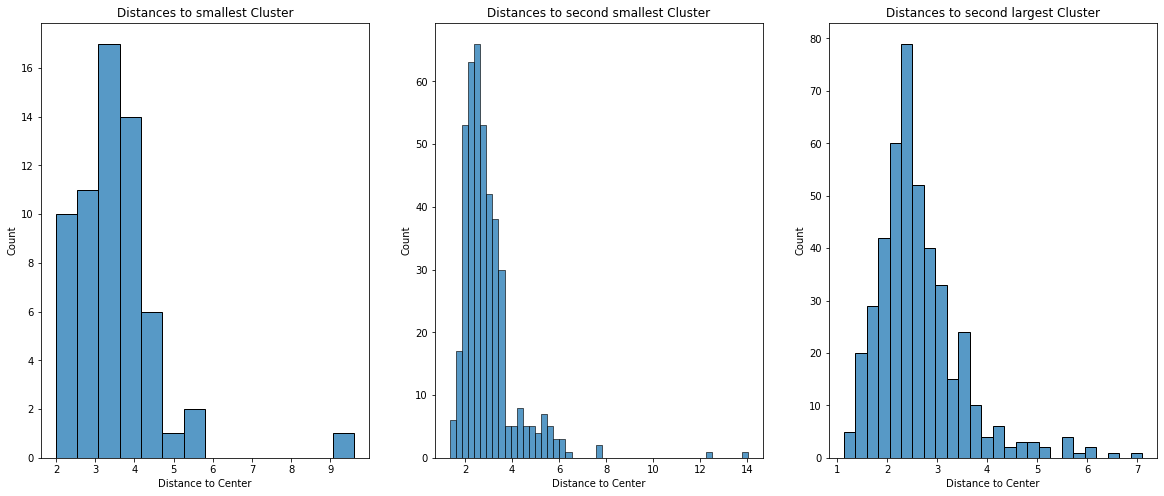

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
plot_labels = ['smallest', 'second smallest', 'second largest', 'largest']

for i, (ax, cluster_distances) in enumerate(zip(np.ravel(axes), distances)):
    sns.histplot(cluster_distances, ax=ax)
    ax.set_xlabel('Distance to Center')
    ax.set_ylabel('Count')
    ax.set_title(f'Distances to {plot_labels[i]} Cluster')

plt.show()

The first I note is that these are not normally distributed. This means I cannot use something like z-scores to determine what outliers are and the 1.5*IQR rule of thumb loses its usefulness. Note, however, that each plot shows that the density of points drops off fairly sharply after some threshold for each cluster.

I can simply find a point below which 95% of distances are found, and consider anything further away to be an outlier.

In [49]:
distance_thresholds = [np.quantile(cluster_distances, q=0.95) for cluster_distances in distances]

distance_thresholds

[4.797361934988, 5.2398782635603975, 4.177973222592961]

Having calculated the thresholds, we can compare them to the histograms of distance distributions. Beyond each of these thresholds, the clusters are clearly not very densely populated.

Next, I can examine songs in the training set that are further away from the center than the thresholds, if any, to see if they ought to be considered outliers.

In [50]:
cluster_beyond_threshold_idx = []
for cluster_idx, cluster_distances in enumerate(distances):
    beyond_threshold_idx = [distance_idx for distance_idx,distance in enumerate(cluster_distances) if distance > distance_thresholds[cluster_idx]] # recall distances and thresholds ordered by increasing cluster size
    cluster_beyond_threshold_idx.append(beyond_threshold_idx)

In [51]:
print(f'The following songs are far away from the center of the smallest cluster')
df[df['cluster_labels']==sorted_cluster_labels[0]].reset_index().loc[cluster_beyond_threshold_idx[0]][song_info]

The following songs are far away from the center of the smallest cluster


track_name                 artist              album_name
29  Let Fall the Curtain           Agent Fresco                Destrier
32                 Zebra  Oneohtrix Point Never            R Plus Seven
45             High Rise          S U R V I V E                  RR7349
60              Homeland             Sarpanitum  Blessed Be My Brothers

In [52]:
print(f'The following songs are far away from the center of the middle-sized cluster')
df[df['cluster_labels']==sorted_cluster_labels[1]].reset_index().loc[cluster_beyond_threshold_idx[1]][song_info]

The following songs are far away from the center of the middle-sized cluster


track_name                       artist  \
37                           Glitch Cannon             Artificial Brain   
41                                Ordalian                    Latitudes   
88                                 Requiem       Der Weg einer Freiheit   
103                                Vectors               Haunted Shores   
130        Ormer Til Armer, Maane Til Hode                       Djevel   
139                     In Service of Time                 Abysmal Dawn   
142                                  Ruins                 Shade Empire   
208                         I - Remastered                    Meshuggah   
214                      Tribe of Eternity                    Catamenia   
221                            Lost Ghosts                    Red Scalp   
224                            Termination          Book Of Black Earth   
265                  The Hyperion Threnody                      Mechina   
281              To Crawl Under One's Skin                     Neurosis   
287             Blaise Bailey Finnegan III  Godspeed You! Black Emperor   
335  Soliloquy of the Stigmatised Shepherd        The Ruins Of Beverast   
369                    In the Name of Amun                         Nile   
372                  Veil of Transcendence                      Abyssal   
374                             Into Decay                    Meshuggah   
377                     Matriarch`s Lament                       Mistur   
394             A Shield With An Iron Face                         Absu   
397                         Wretched Blues                Ghost Brigade   
420                    Ashes of the Damned                       Abbath   

                          album_name  
37                  Artificial Brain  
41                      Old Sunlight  
88                           Stellar  
103                          Viscera  
130  Ormer Til Armer, Maane Til Hode  
139  Leveling the Plane of Existence  
142                     Omega Arcane  
208              I (Special Edition)  
214                   Location: COLD  
221                      Lost Ghosts  
224               The Cold Testament  
265                          Acheron  
281                    Souls At Zero  
287    Slow Riot for New Zero Kanada  
335             Rain Upon the Impure  
369     What Should Not Be Unearthed  
372                  Antikatastaseis  
374      The Violent Sleep of Reason  
377                      In Memoriam  
394                             Tara  
397           Iv: One with the Storm  
420                           Abbath

In [53]:
print(f'The following songs are far away from the center of the largest cluster')
df[df['cluster_labels']==sorted_cluster_labels[2]].reset_index().loc[cluster_beyond_threshold_idx[2]][song_info]

The following songs are far away from the center of the largest cluster


track_name                 artist  \
16                     Evidence of Near Death (E.N.D.)              Katalepsy   
39                                    Impious Dystopia          Ancient Bards   
51                                    The Power Cosmiq            Cannibal Ox   
111                                           Odd Look               Kavinsky   
164                                            Aurorae              Triptykon   
209                      Welcame (Furyo State of Mind)  Rise Of The Northstar   
223                                            Captive                Leprous   
231                                   Shadows of Death       Rhapsody Of Fire   
260                                       Megatropolis            Iron Savior   
303                         When Crows Tick on Windows          Carach Angren   
309  Sanctuary: Light & Grief - Act Iii: Exiled to ...              Persefone   
316                                  Maddening Disdain                  Arsis   
329                                        Wait For Me           Agent Fresco   
331                                   Sending You Back              Persuader   
334                                  Cuts Like a Knife        Nocturnal Rites   
354                                   For Broken Words      Dark Tranquillity   
358                                  This World of Ice             Orden Ogan   
385                                      Into the Fire               Firewind   
391                                      Into The Soil        Defeated Sanity   
414                                      I Want to Die                 Myrath   
423                                      Runaway Train              Sólstafir   
427                                            Battery              Metallica   

                                           album_name  
16                                      Autopsychosis  
39      Origine (The Black Crystal Sword Saga, Pt. 2)  
51                Blade of the Ronin (Deluxe Edition)  
111                                            OutRun  
164                                   Melana Chasmata  
209                                           Welcame  
223                                            Malina  
231  Symphony of Enchanted Lands II (The Dark Secret)  
260                                      Megatropolis  
303                             This Is No Fairy Tale  
309                                              Core  
316                            A Celebration Of Guilt  
329                          Destrier (Bonus Edition)  
331                                   When Eden Burns  
334                                    Grand Illusion  
354                                         Construct  
358                                        To the End  
385                                   The Premonition  
391                  Disposal Of The Dead // Dharmata  
414                                            Legacy  
423                             Fjara / Runaway Train  
427                                 Master Of Puppets

These are all acceptable "losses."

In [55]:
filename = 'thresholds.sav'
pickle.dump(distance_thresholds, open(filename, 'wb'))

## Full Classification Pipeline
The model will be used as follows

1) As a user to input information about songs (i.e. a song name and an artist or album name)
2) Retrieve data on the songs needed for analysis from the Spotify API
3) Transform features as needed, and classify the songs
4) Determine if any songs are too far from cluster centers; those are outliers
5) Tell the user whether each song they inputted are members of some class or outliers

For brevity, I do not include the code I used to perform these tasks in this notebook; however, all of that code can be found in the repository in which this notebook was originally located. Specifically, you can run main.py as a command line script to perform the steps listed above. The files retrive_new_tracks.py and classifier_and_distance_dict.py contain code used to retrieve new songs from Spotify and two classes written to simplify the code in main.py respectively.

# Conclusion
In this notebook, songs were successfully clustered into three clusters. Those clusters were used as labels to train a classifier. Distances to appropriate cluster centers were used to determine whether a classification was appropriate.